In [149]:
import pandas as pd 
import matplotlib.pyplot as plt 

import numpy as np 

from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from keras.layers import InputLayer, LSTM, Dense, Flatten
from keras.models import Sequential

import tensorflow as tf 
import seaborn as sns


# Get Data from File

In [2]:
dataFileName = "CombinedData.csv"
df = pd.read_csv(dataFileName)
data = df[["datetime", "temp", "humidity", "precip"]]

# Data Analysis

Analysis of Temperature, Precipitation and Humidity over the past few years

In [3]:
# Temperature Data Analysis
t_data = data[["datetime", "temp"]].copy()
t_data.rename(columns={"datetime" : "Date", "temp" : "Temp"}, inplace = True)
t_data["Month"] = pd.DatetimeIndex(t_data["Date"]).month 
t_data["Year"] = pd.DatetimeIndex(t_data["Date"]).year

In [4]:
t_data["Year"].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023])

In [13]:
# Mean (Per Year)
yearly_mean = t_data.groupby(by="Year").mean(numeric_only = True)
yearly_mean.drop(columns=["Month"], inplace = True, axis = 1)

# Mean of Yearly Mean
total_yearly_mean = yearly_mean["Temp"].mean()
print("Total Yearly Mean:", total_yearly_mean)

# Adjust Current Yearly Mean to Overall Mean
yearly_mean["TotalMeanDiff"] = total_yearly_mean - yearly_mean["Temp"]

# Preview Yearly Mean
yearly_mean

Total Yearly Mean: 27.92804644808743


,Temp,TotalMeanDiff
Year,,
2000,27.621858,0.306189
2001,27.863836,0.064211
2002,27.536164,0.391882
2003,27.560822,0.367225
2004,27.563388,0.364658
2005,27.667671,0.260375
2006,27.782466,0.145581
2007,27.908767,0.019279
2008,27.552186,0.375861


In [23]:
# Augment T Data to Match the Total Mean Diff
t_augment_data = t_data.copy()
t_augment_data["YearAugment"] = t_augment_data["Temp"]
yearly_mean_dict = yearly_mean["TotalMeanDiff"].to_dict()

for year in yearly_mean.index:
    t_augment_data.loc[t_augment_data["Year"] == year, "YearAugment"] += yearly_mean_dict[year]    

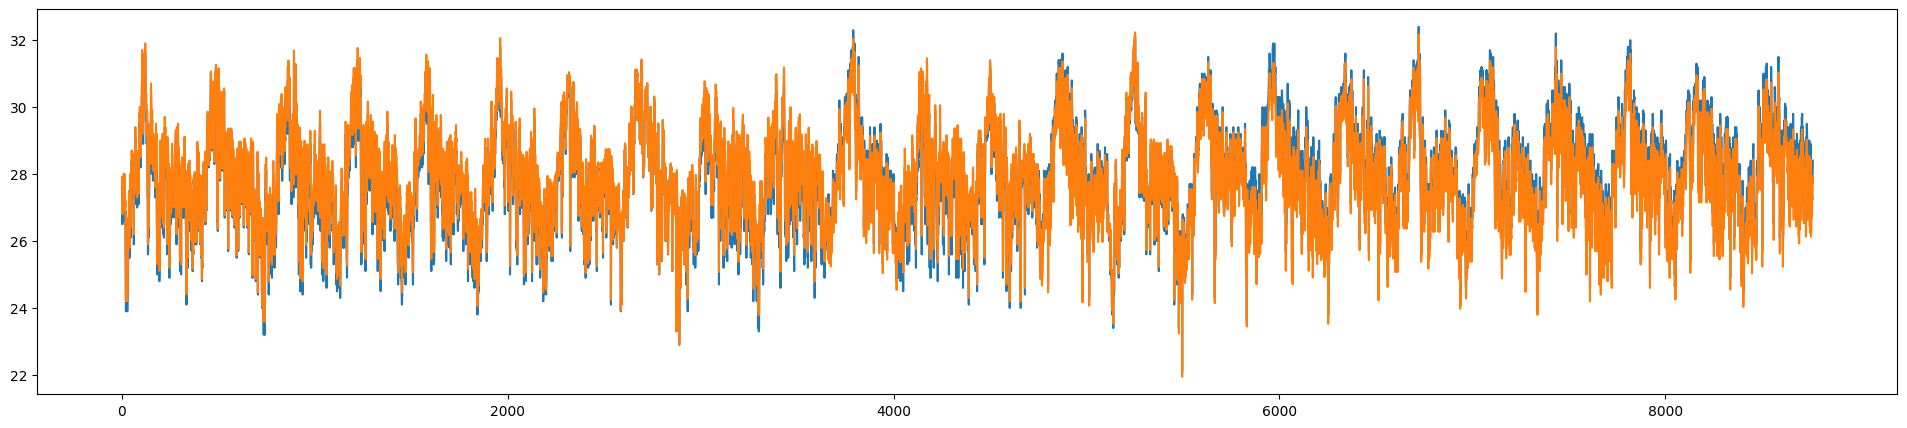

In [26]:
plt.figure(figsize=(24, 5))
plt.plot(t_augment_data["Temp"])
plt.plot(t_augment_data["YearAugment"])
plt.show()

In [80]:
# Check if it was indeed changed, all means for each year should not be equal to total yearly mean
# Effectively Removing Seasonality (Year Wise)
t_augment_data.groupby(by="Year").mean(numeric_only=True)["YearAugment"].unique(), total_yearly_mean

(array([27.92804645, 27.92804645]), 27.92804644808743)

In [81]:
# Monthly Data Time (Set it to be unique for each month and year)
t_augment_data["MonthYearCombination"] = t_augment_data["Year"] * 10000 + t_augment_data["Month"]

In [83]:
# Get Mean of Month and Year (Unique per Month and Year)
# Use Year Augment as this would be the second step for removing seasonality
month_year_mean = t_augment_data.groupby(by = "MonthYearCombination").mean(numeric_only = True)
total_month_year_mean = month_year_mean["YearAugment"].mean()
month_year_mean["TotalMeanDiff"] = total_month_year_mean - month_year_mean["YearAugment"]

In [84]:
month_year_mean.head()

,Temp,Month,Year,YearAugment,TotalMeanDiff
MonthYearCombination,,,,,
20000001,26.300000,1.0,2000.0,26.606189,1.319266
20000002,26.817241,2.0,2000.0,27.123430,0.802024
20000003,27.825806,3.0,2000.0,28.131995,-0.206541
20000004,29.976667,4.0,2000.0,30.282855,-2.357401
20000005,28.580645,5.0,2000.0,28.886834,-0.961379


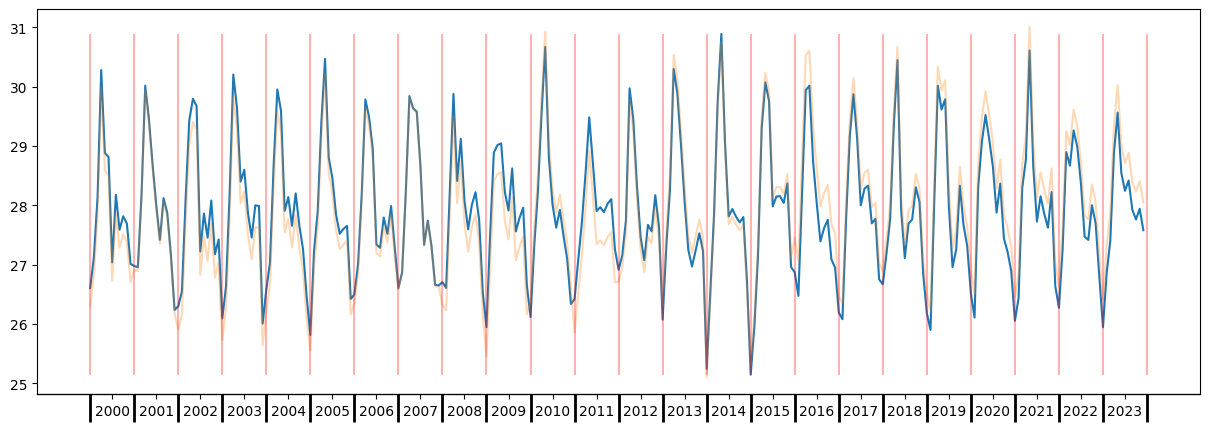

In [88]:
fig, ax = plt.subplots(figsize=(15, 5))

max_y = month_year_mean["YearAugment"].max()
min_y = month_year_mean["YearAugment"].min()


x_locations = np.arange(0, len(t_data["Year"].unique()) * 12 + 1, 12)
year_titles = np.arange(2000, len(t_data["Year"].unique()) + 2000)

year_title_locations = np.arange(6, len(t_data["Year"].unique()) * 12 + 1, 12)

year_title_axis = ax.secondary_xaxis(location = 0)
year_title_axis.set_xticks(year_title_locations, labels=year_titles)

year_bounds = ax.secondary_xaxis(location = 0)
year_bounds.set_xticks(x_locations, labels=[])
year_bounds.tick_params('x', width=2, length=20)


ax.plot(np.arange(0, len(month_year_mean)), month_year_mean["YearAugment"].tolist())
ax.plot(np.arange(0, len(month_year_mean)), month_year_mean["Temp"].tolist(), alpha = 0.3)
ax.set_xticks([])
ax.vlines(x_locations, min_y, max_y, colors=["red"], alpha = 0.3)
plt.show()

In [66]:
total_month_year_mean, total_yearly_mean

(27.925454336203956, 27.92804644808743)

In [89]:
final_t_augment_data

,Date,Temp,Month,Year,YearAugment,MonthYearCombination,MonthYearAugment
0,2000-01-01,27.6,1,2000,27.906189,20000001,27.906189
1,2000-01-02,27.4,1,2000,27.706189,20000001,27.706189
2,2000-01-03,26.5,1,2000,26.806189,20000001,26.806189
3,2000-01-04,26.5,1,2000,26.806189,20000001,26.806189
4,2000-01-05,26.8,1,2000,27.106189,20000001,27.106189
...,...,...,...,...,...,...,...
8761,2023-12-27,27.4,12,2023,26.932156,20230012,26.932156
8762,2023-12-28,27.8,12,2023,27.332156,20230012,27.332156
8763,2023-12-29,27.7,12,2023,27.232156,20230012,27.232156
8764,2023-12-30,28.0,12,2023,27.532156,20230012,27.532156


In [94]:
final_t_augment_data = t_augment_data.copy()
final_t_augment_data["MonthYearAugment"] = final_t_augment_data["YearAugment"]
month_year_mean_dict = month_year_mean["TotalMeanDiff"].to_dict()

for month_year in tqdm(month_year_mean.index):
    final_t_augment_data.loc[final_t_augment_data["MonthYearCombination"] == month_year, "MonthYearAugment"] += month_year_mean_dict[month_year]


# # Augment T Data to Match the Total Mean Diff
# t_augment_data = t_data.copy()
# t_augment_data["YearAugment"] = t_augment_data["Temp"]
# yearly_mean_dict = yearly_mean["TotalMeanDiff"].to_dict()

# for year in yearly_mean.index:
#     t_augment_data.loc[t_augment_data["Year"] == year, "YearAugment"] += yearly_mean_dict[year]    

100%|██████████| 288/288 [00:00<00:00, 700.19it/s]


In [93]:
final_t_augment_data

,Date,Temp,Month,Year,YearAugment,MonthYearCombination,MonthYearAugment
0,2000-01-01,27.6,1,2000,27.906189,20000001,29.225454
1,2000-01-02,27.4,1,2000,27.706189,20000001,29.025454
2,2000-01-03,26.5,1,2000,26.806189,20000001,28.125454
3,2000-01-04,26.5,1,2000,26.806189,20000001,28.125454
4,2000-01-05,26.8,1,2000,27.106189,20000001,28.425454
...,...,...,...,...,...,...,...
8761,2023-12-27,27.4,12,2023,26.932156,20230012,27.277067
8762,2023-12-28,27.8,12,2023,27.332156,20230012,27.677067
8763,2023-12-29,27.7,12,2023,27.232156,20230012,27.577067
8764,2023-12-30,28.0,12,2023,27.532156,20230012,27.877067


In [95]:
# Get Mean of Month and Year (Unique per Month and Year)
# Use Year Augment as this would be the second step for removing seasonality
p_month_year_mean = final_t_augment_data.groupby(by = "MonthYearCombination").mean(numeric_only = True)


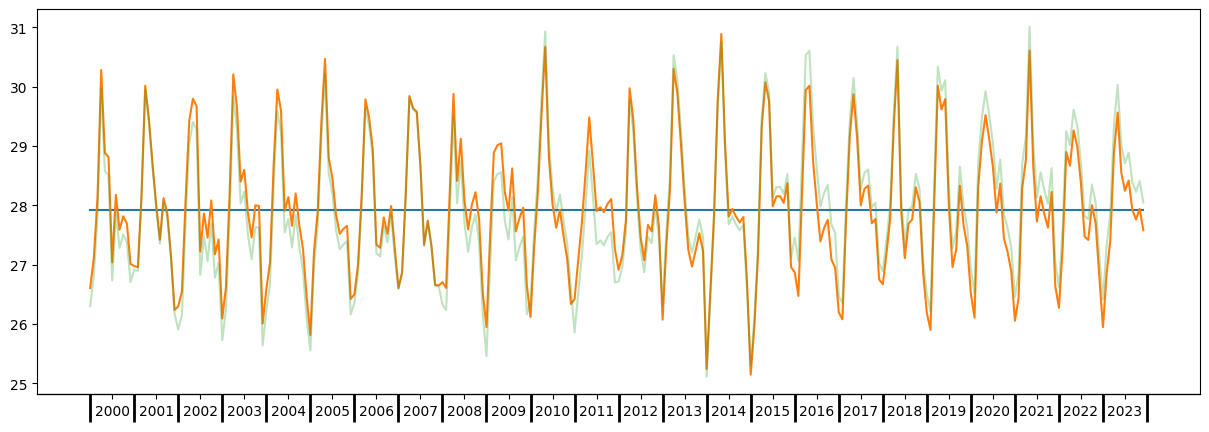

In [98]:
fig, ax = plt.subplots(figsize=(15, 5))

max_y = p_month_year_mean["MonthYearAugment"].max()
min_y = p_month_year_mean["MonthYearAugment"].min()


x_locations = np.arange(0, len(t_data["Year"].unique()) * 12 + 1, 12)
year_titles = np.arange(2000, len(t_data["Year"].unique()) + 2000)

year_title_locations = np.arange(6, len(t_data["Year"].unique()) * 12 + 1, 12)

year_title_axis = ax.secondary_xaxis(location = 0)
year_title_axis.set_xticks(year_title_locations, labels=year_titles)

year_bounds = ax.secondary_xaxis(location = 0)
year_bounds.set_xticks(x_locations, labels=[])
year_bounds.tick_params('x', width=2, length=20)


ax.plot(np.arange(0, len(p_month_year_mean)), p_month_year_mean["MonthYearAugment"].tolist())
ax.plot(np.arange(0, len(p_month_year_mean)), p_month_year_mean["YearAugment"].tolist())
ax.plot(np.arange(0, len(p_month_year_mean)), p_month_year_mean["Temp"].tolist(), alpha = 0.3)
ax.set_xticks([])
ax.vlines(x_locations, min_y, max_y, colors=["red"], alpha = 0.3)
plt.show()

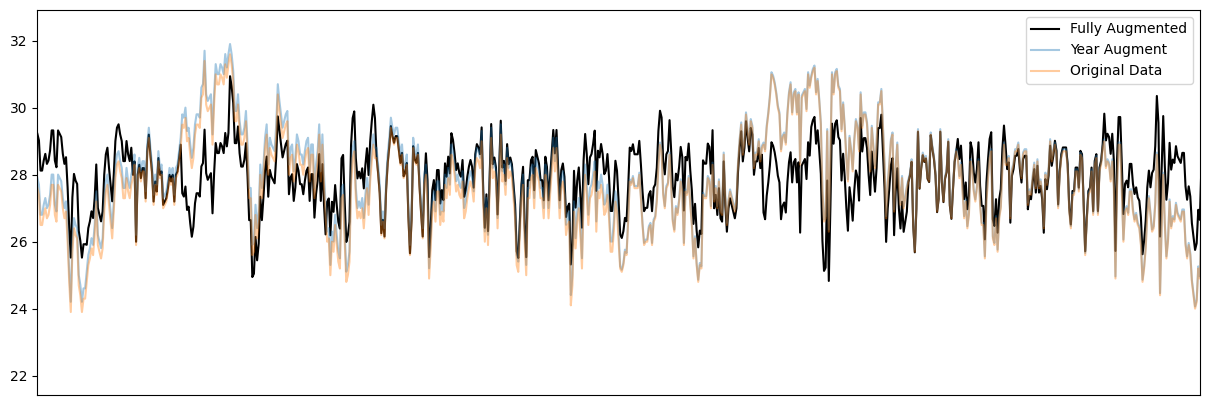

In [109]:
# Plot the Changes starting from Original, Year - Augmented, Month & Year - Augmented
fig, ax = plt.subplots(figsize=(15, 5))

max_y = final_t_augment_data["MonthYearAugment"].max()
min_y = final_t_augment_data["MonthYearAugment"].min()

ax.plot(final_t_augment_data["MonthYearAugment"].tolist(), alpha = 1, label = "Fully Augmented", color = "black")
ax.plot(final_t_augment_data["YearAugment"].tolist(), alpha = 0.4, label = "Year Augment")
ax.plot(final_t_augment_data["Temp"].tolist(), alpha = 0.4, label = "Original Data")
plt.legend()
ax.set_xlim(0, 365 * 2)
ax.set_xticks([])
# ax.vlines(x_locations, min_y, max_y, colors=["red"], alpha = 0.3)
plt.show()

In [119]:
ymT, mymT, ftT = yearly_mean["Temp"], month_year_mean.groupby(by="Year").mean(numeric_only=True)["YearAugment"], final_t_augment_data.groupby(by="Year").mean(numeric_only = True)["MonthYearAugment"]

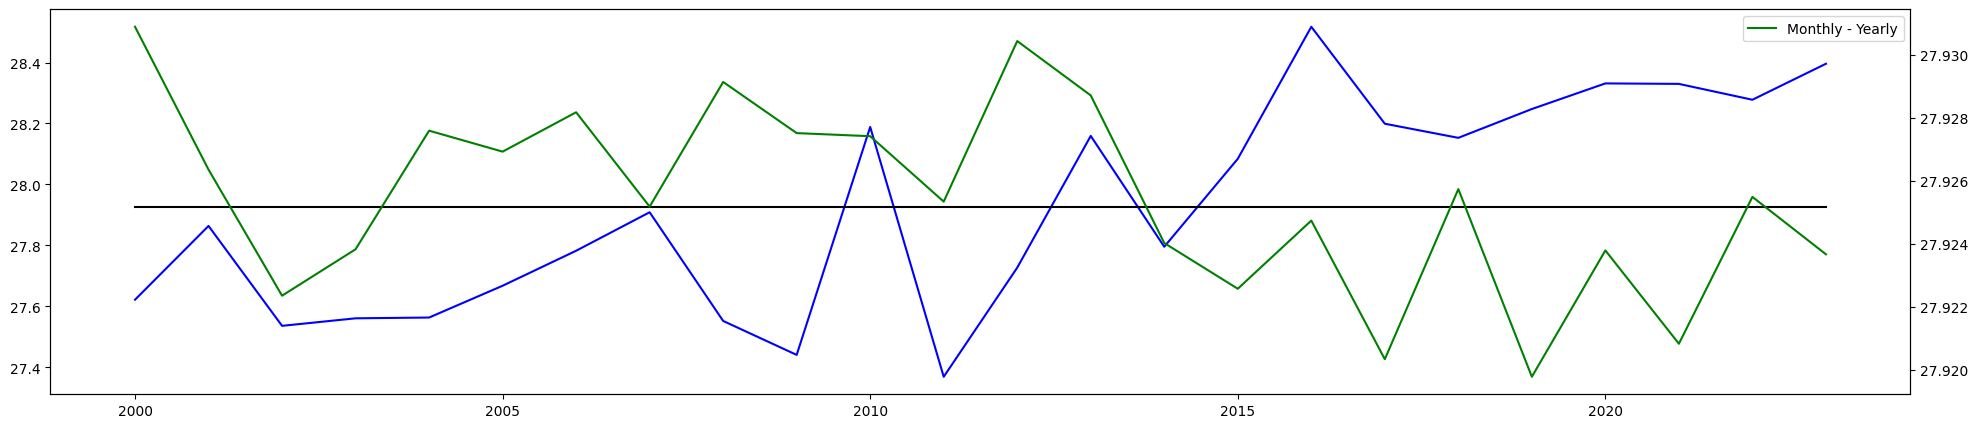

In [127]:
fig, ax1 = plt.subplots(figsize = (24, 5))
ax1.plot(ymT, label = "Yearly", color = "blue")
ax1.plot(ftT, label = "Final Augmented", color = "black")

ax2 = ax1.twinx()
ax2.plot(mymT, label = "Monthly - Yearly", color = "green")
plt.show()

In [128]:
yearly_mean.head()

,Temp,TotalMeanDiff
Year,,
2000,27.621858,0.306189
2001,27.863836,0.064211
2002,27.536164,0.391882
2003,27.560822,0.367225
2004,27.563388,0.364658


In [129]:
month_year_mean.head()

,Temp,Month,Year,YearAugment,TotalMeanDiff
MonthYearCombination,,,,,
20000001,26.300000,1.0,2000.0,26.606189,1.319266
20000002,26.817241,2.0,2000.0,27.123430,0.802024
20000003,27.825806,3.0,2000.0,28.131995,-0.206541
20000004,29.976667,4.0,2000.0,30.282855,-2.357401
20000005,28.580645,5.0,2000.0,28.886834,-0.961379


In [130]:
yearly_mean["Temp"]

Year
2000    27.621858
2001    27.863836
2002    27.536164
2003    27.560822
2004    27.563388
2005    27.667671
2006    27.782466
2007    27.908767
2008    27.552186
2009    27.440822
2010    28.188493
2011    27.369041
2012    27.727049
2013    28.159178
2014    27.795616
2015    28.084110
2016    28.517213
2017    28.199178
2018    28.152877
2019    28.247397
2020    28.331421
2021    28.329863
2022    28.277808
2023    28.395890
Name: Temp, dtype: float64

In [146]:
# Yearly Mean - YM
# Monthly and Yearly Mean - MYLM
# Data Preparation for Mean Prediction

train_size = 0.7
test_size = 0.3

WINDOW_SIZE = 2
YM_Copy = yearly_mean["Temp"].to_list()
YM_Copy_X = []
YM_Copy_Y = []
for i in range(WINDOW_SIZE, len(yearly_mean) - WINDOW_SIZE):
    YM_Copy_X.append(YM_Copy[i : i + WINDOW_SIZE])
    YM_Copy_Y.append(YM_Copy[i + WINDOW_SIZE])

MYLM_Copy = month_year_mean["YearAugment"].to_list()
MYLM_Copy_X = []
MYLM_Copy_Y = []
for i in range(WINDOW_SIZE, len(month_year_mean) - WINDOW_SIZE):
    MYLM_Copy_X.append(MYLM_Copy[i : i + WINDOW_SIZE])
    MYLM_Copy_Y.append(MYLM_Copy[i + WINDOW_SIZE])

YM_TRAIN_X = YM_Copy_X[:int(train_size * len(YM_Copy_X))]
YM_TEST_X = YM_Copy_X[int(train_size * len(YM_Copy_X)):]

YM_TRAIN_Y = YM_Copy_Y[:int(train_size * len(YM_Copy_Y))]
YM_TEST_Y = YM_Copy_Y[int(train_size * len(YM_Copy_Y)):]

MYLM_TRAIN_X = MYLM_Copy_X[:int(train_size * len(MYLM_Copy_X))]
MYLM_TEST_X = MYLM_Copy_X[int(train_size * len(MYLM_Copy_X)):]

MYLM_TRAIN_Y = MYLM_Copy_Y[:int(train_size * len(MYLM_Copy_Y))]
MYLM_TEST_Y = MYLM_Copy_Y[int(train_size * len(MYLM_Copy_Y)):]

In [155]:
# Yearly_Mean_Predictor = SVR(kernel = "rbf")
Yearly_Mean_Predictor = RandomForestRegressor()
Yearly_Mean_Predictor.fit(YM_TRAIN_X, YM_TRAIN_Y)

RandomForestRegressor()

In [156]:
Y_PRED = Yearly_Mean_Predictor.predict(YM_TEST_X)

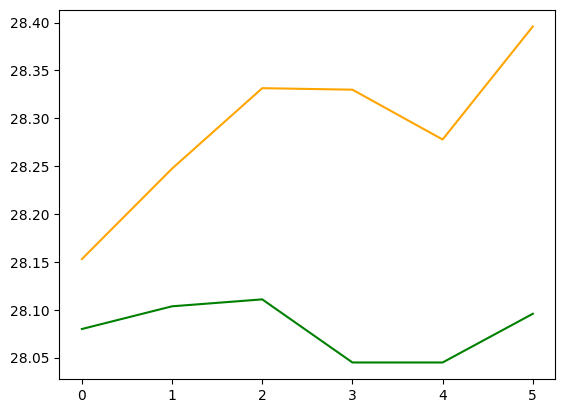

In [157]:
plt.figure()
plt.plot(Y_PRED, label = "Predictions", color = "green")
plt.plot(YM_TEST_Y, label = "Real", color = "orange")
plt.show()

In [164]:
SlidingWindow = YM_TRAIN_X[-1]

R_Y_PRED = []

for x in range(len(YM_TEST_Y)):
    current_prediction = Yearly_Mean_Predictor.predict(np.array([SlidingWindow]))
    R_Y_PRED.append(current_prediction[0])

    SlidingWindow = np.roll(SlidingWindow, -1)
    SlidingWindow[-1] = current_prediction[0]


In [165]:
R_Y_PRED

[28.10598978216932,
 28.143876562616956,
 28.14615565536342,
 28.122144426978057,
 28.133626147166698,
 28.141527786510956]

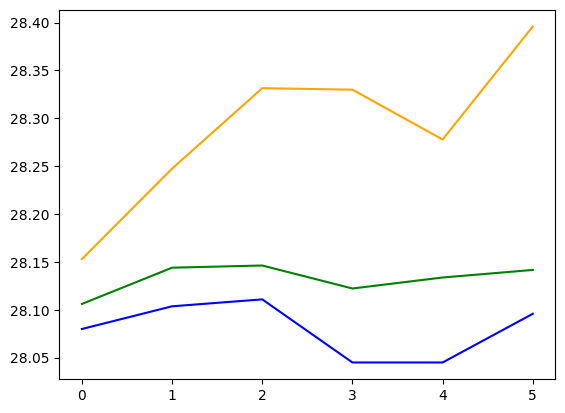

In [167]:
plt.figure()
plt.plot(Y_PRED, label = "Predictions", color = "blue")
plt.plot(R_Y_PRED, label = "R Predictions", color = "green")
plt.plot(YM_TEST_Y, label = "Real", color = "orange")
plt.show()

In [ ]:
Month_Year_Mean_Predictor = SVR(kernel = "rbf")

# Old Method
This Method uses Random Noise to Add as an input

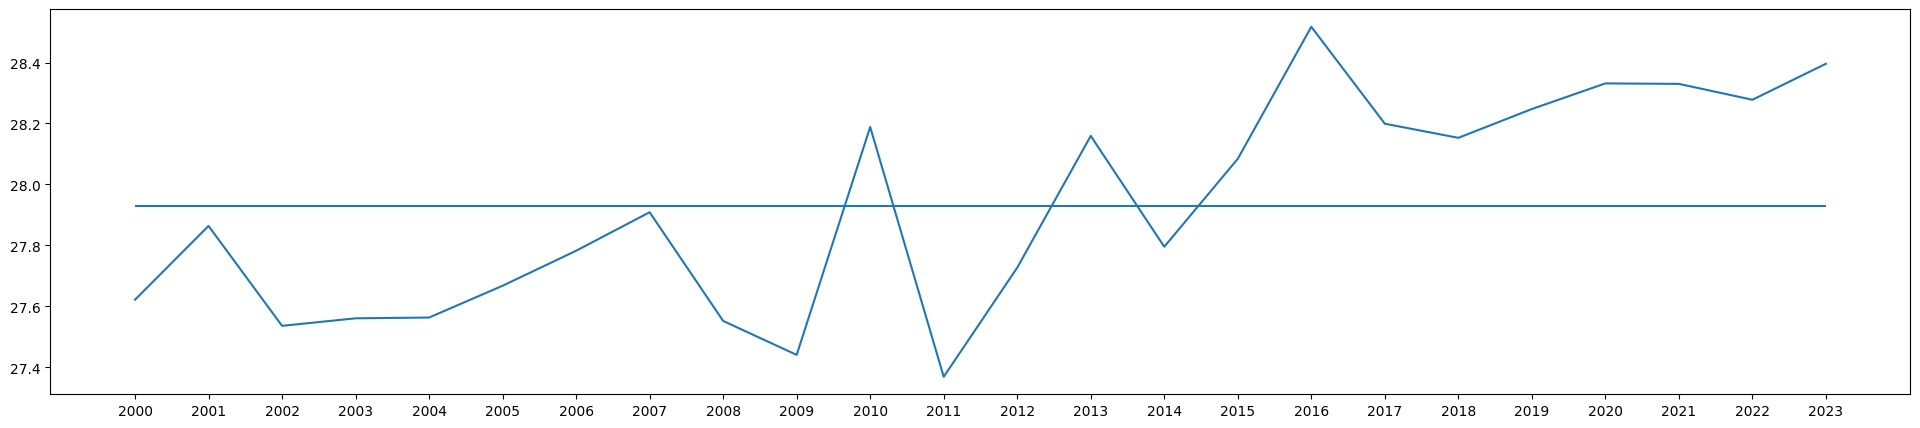

In [73]:
plt.figure(figsize=(24, 5))
plt.hlines([yearly_mean.mean()], xmin = yearly_mean.index[0], xmax = yearly_mean.index[-1])
plt.plot(yearly_mean)
plt.xticks(yearly_mean.index)
plt.show()

In [77]:
yearly_means_df = t_data.groupby(by="Year").mean(numeric_only=True)
start_temp_mean = yearly_means_df["Temp"].to_numpy()[0]
yearly_means_df["TempMean"] = yearly_means_df["Temp"].mean()
yearly_means_df["TempDelta"] = yearly_means_df["Temp"] - yearly_means_df["TempMean"]
yearly_means_df["StartDiff"] = yearly_means_df["Temp"] - start_temp_mean
yearly_means_df.drop(["Month"], inplace=True, axis=1)
yearly_means_df
# yearly_means_df.T


,Temp,TempMean,TempDelta,StartDiff
Year,,,,
2000,27.621858,27.928046,-0.306189,0.000000
2001,27.863836,27.928046,-0.064211,0.241978
2002,27.536164,27.928046,-0.391882,-0.085694
2003,27.560822,27.928046,-0.367225,-0.061036
2004,27.563388,27.928046,-0.364658,-0.058470
2005,27.667671,27.928046,-0.260375,0.045813
2006,27.782466,27.928046,-0.145581,0.160608
2007,27.908767,27.928046,-0.019279,0.286909
2008,27.552186,27.928046,-0.375861,-0.069672


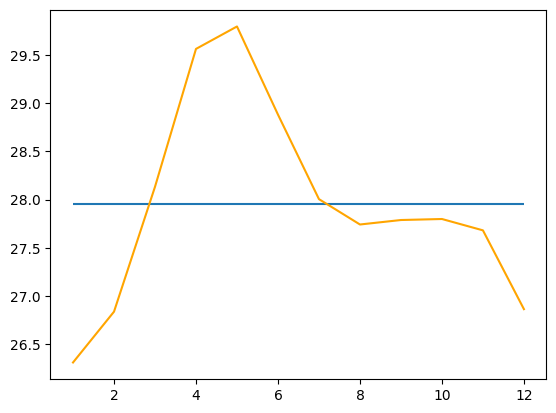

In [37]:
monthly_mean = t_data.groupby(by="Month").mean(numeric_only = True)["Temp"]
plt.hlines([monthly_mean.mean()], xmin = monthly_mean.index[0], xmax = monthly_mean.index[-1])
plt.plot(monthly_mean, color="orange")
plt.show()

In [79]:
# Plot the Data showing the Yearly Mean Per Year, along with their monthly mean


,Date,Temp,Month,Year
0,2000-01-01,27.6,1,2000
1,2000-01-02,27.4,1,2000
2,2000-01-03,26.5,1,2000
3,2000-01-04,26.5,1,2000
4,2000-01-05,26.8,1,2000
...,...,...,...,...
8761,2023-12-27,27.4,12,2023
8762,2023-12-28,27.8,12,2023
8763,2023-12-29,27.7,12,2023
8764,2023-12-30,28.0,12,2023


In [ ]:
# Plot the Data of the monthly mean only, without the yearly mean after it was normalized now

# Temperature

Preview Temperature Data first (4) Years of Data

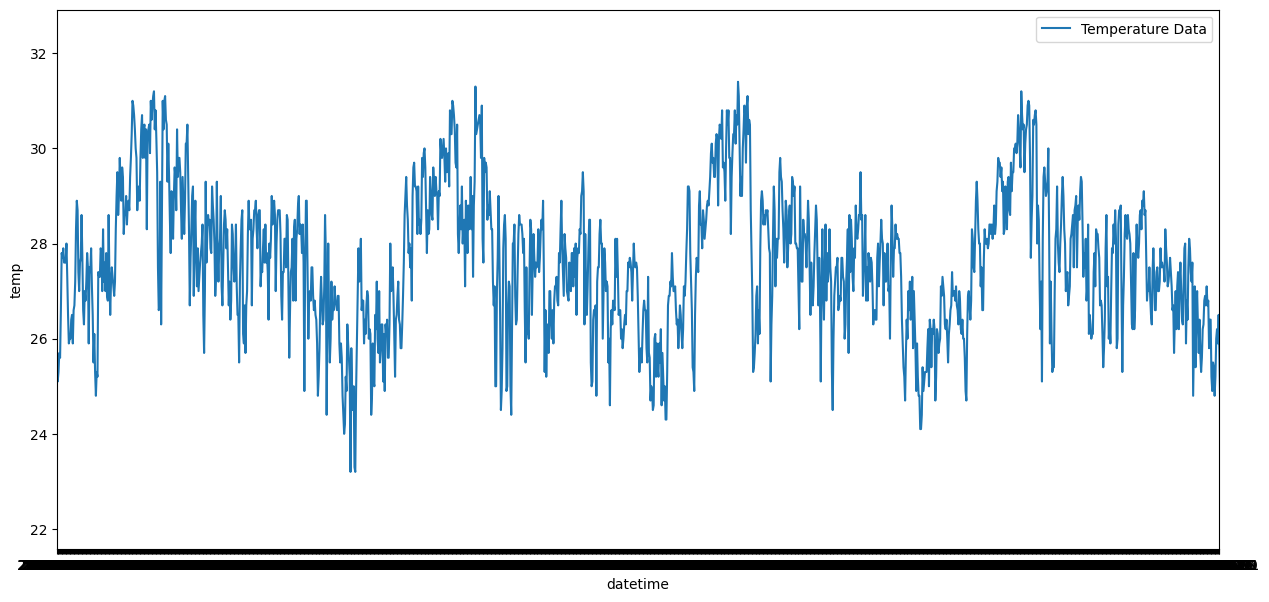

In [3]:
NUM_YEARS = 4
PREVIEW_LENGTH = int(4 * 365.25)
plt.figure(figsize = (15, 7))
plt.xlim(0, PREVIEW_LENGTH)
sns.lineplot(x=data["datetime"], y = data["temp"], label="Temperature Data")
plt.legend()
plt.show()

In [145]:
# Copy Data to preserve Original Data
temperature_data = data[["datetime", "temp"]].copy()

# Just Rename Data
temperature_data.rename(columns={"datetime" : "Date", "temp" : "Temp"}, inplace = True)
temperature_data["TempMean"] = temperature_data["Temp"]

# Put Month and Year Data based on Date Column
temperature_data["Month"] = pd.DatetimeIndex(temperature_data["Date"]).month 
temperature_data["Year"] = pd.DatetimeIndex(temperature_data["Date"]).year

In [146]:
# Reset Index of Temperature Data
YEAR_LENGTH = 3
# DATASET_LENGTH = YEAR_LENGTH * 365
DATASET_LENGTH = 2000
temperature_data = temperature_data.reset_index()[:DATASET_LENGTH]
temperature_data.head()

,index,Date,Temp,TempMean,Month,Year
0,0,2001-01-01,25.2,25.2,1,2001
1,1,2001-01-02,25.1,25.1,1,2001
2,2,2001-01-03,25.3,25.3,1,2001
3,3,2001-01-04,25.7,25.7,1,2001
4,4,2001-01-05,25.6,25.6,1,2001


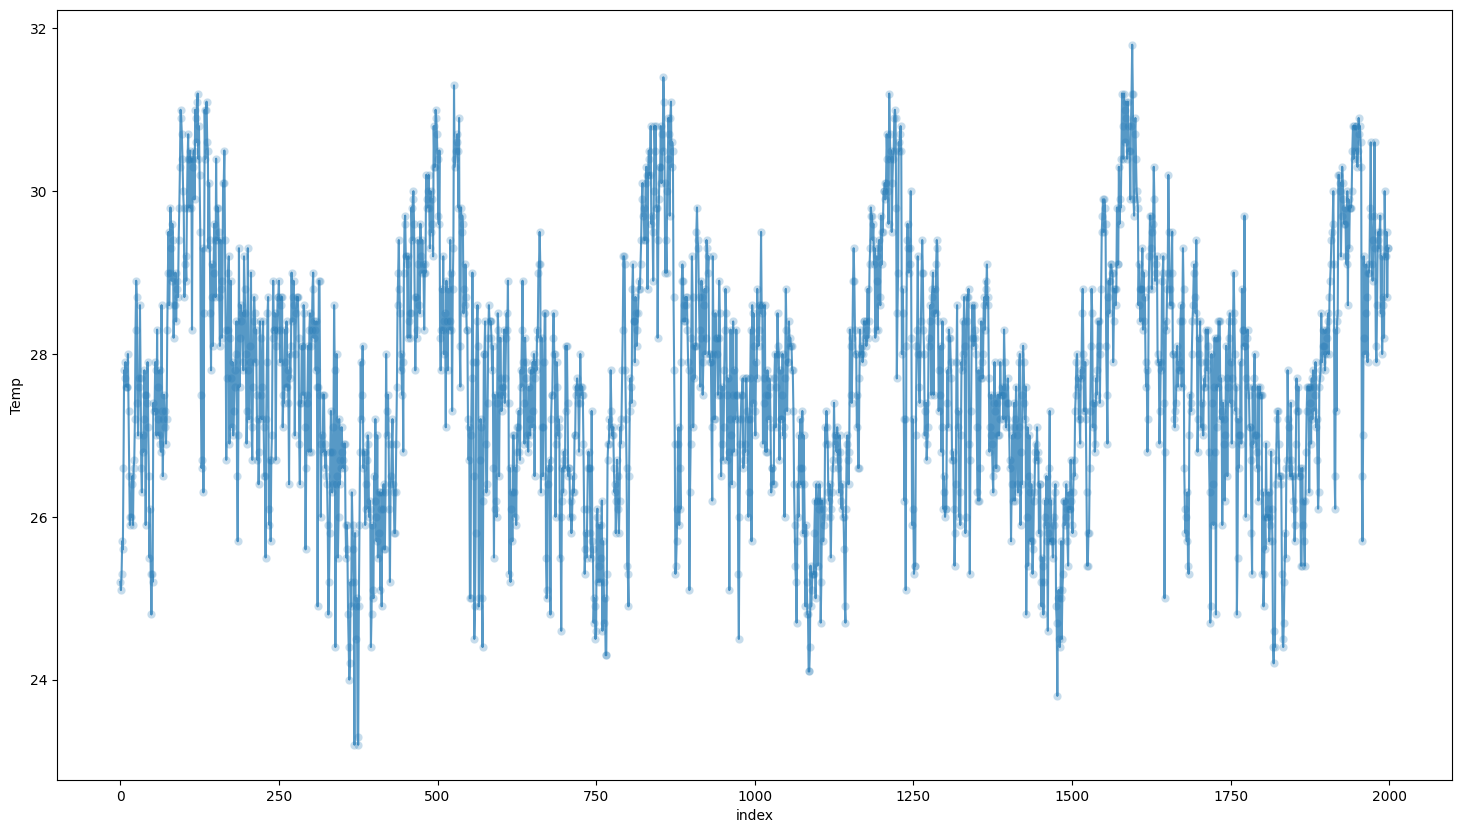

In [147]:
# Display Initial Temeprature Readings
plt.figure(figsize=(18, 10))
sns.scatterplot(data = temperature_data, x = "index", y = "Temp", alpha = 0.25)
sns.lineplot(data = temperature_data, x = "index", y = "Temp", alpha = 0.75)
plt.show()


# Check For Seasonality

Both for Months and For Year

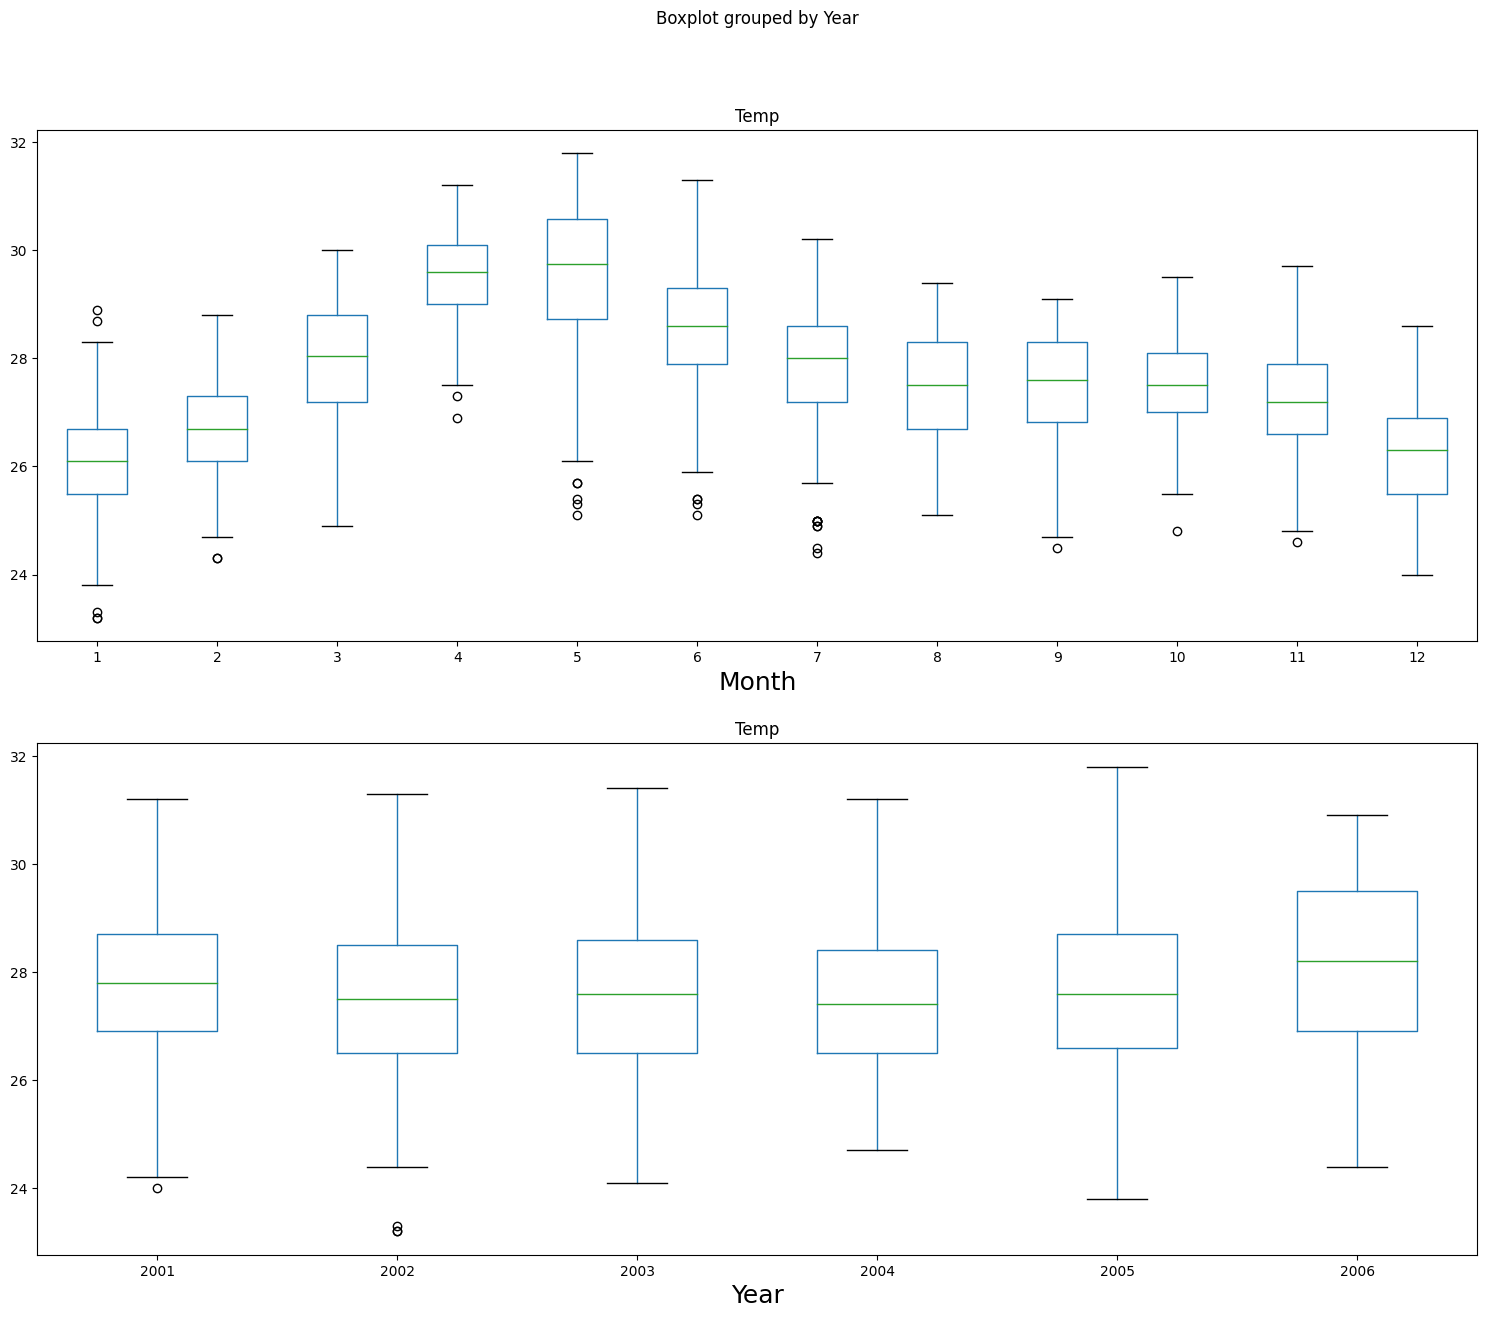

In [148]:
# Seasonality Check for Month

# Pandas Require an Axis therefore, subplots is used
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 15))
temperature_data.boxplot(column = ["Temp"], by = "Month", ax = ax1)
temperature_data.boxplot(column = ["Temp"], by = "Year", ax = ax2)
ax1.grid(False)
ax2.grid(False)
ax1.set_xlabel("Month", fontsize = 18)
ax2.set_xlabel("Year", fontsize = 18)
plt.show()

# Remove Seasonality

From Source, they only subtract therefore only satisfying the numerator for mean numeralization. Standard Deviation would be used later for the prediction and not for the Normalization (Which should be but it is what it is)

Have to Experiment with adding the denominator which would be using the max(x) - min(x) with x as the feature.

Although Adding the Denominator would also mean having to take note of the min, and max per month along with the whole year or just the whole year as it would be needed for inverse transformation

In [149]:
# Get the Monthly Mean (Using the Month Group Made on top)
monthly_mean = temperature_data.groupby(by = "Month").mean(numeric_only = True)["Temp"]

# Adjust the Mean Temperature for such day -> Normalize Per Month (Mean Normalization)
for month in temperature_data["Month"].unique():
    temperature_data.loc[temperature_data["Month"] == month, "TempMean"] -= monthly_mean[month]

# Mean for the whole Normalized Group (Whole Training Set Normalization)
whole_training_set_mean = temperature_data["TempMean"].mean() # Remember this
temperature_data["TempMean"] -= whole_training_set_mean
print("Whole Training Set Mean:", whole_training_set_mean)

Whole Training Set Mean: 6.394884621840901e-17


In [204]:
monthly_mean.to_dict()

{1: 26.110752688172045,
 2: 26.63550295857988,
 3: 27.944086021505377,
 4: 29.534444444444443,
 5: 29.478494623655912,
 6: 28.49306358381503,
 7: 27.795483870967743,
 8: 27.439999999999998,
 9: 27.461333333333332,
 10: 27.553548387096775,
 11: 27.159333333333333,
 12: 26.218064516129033}

# Check Non - Seasonal Transformed Data

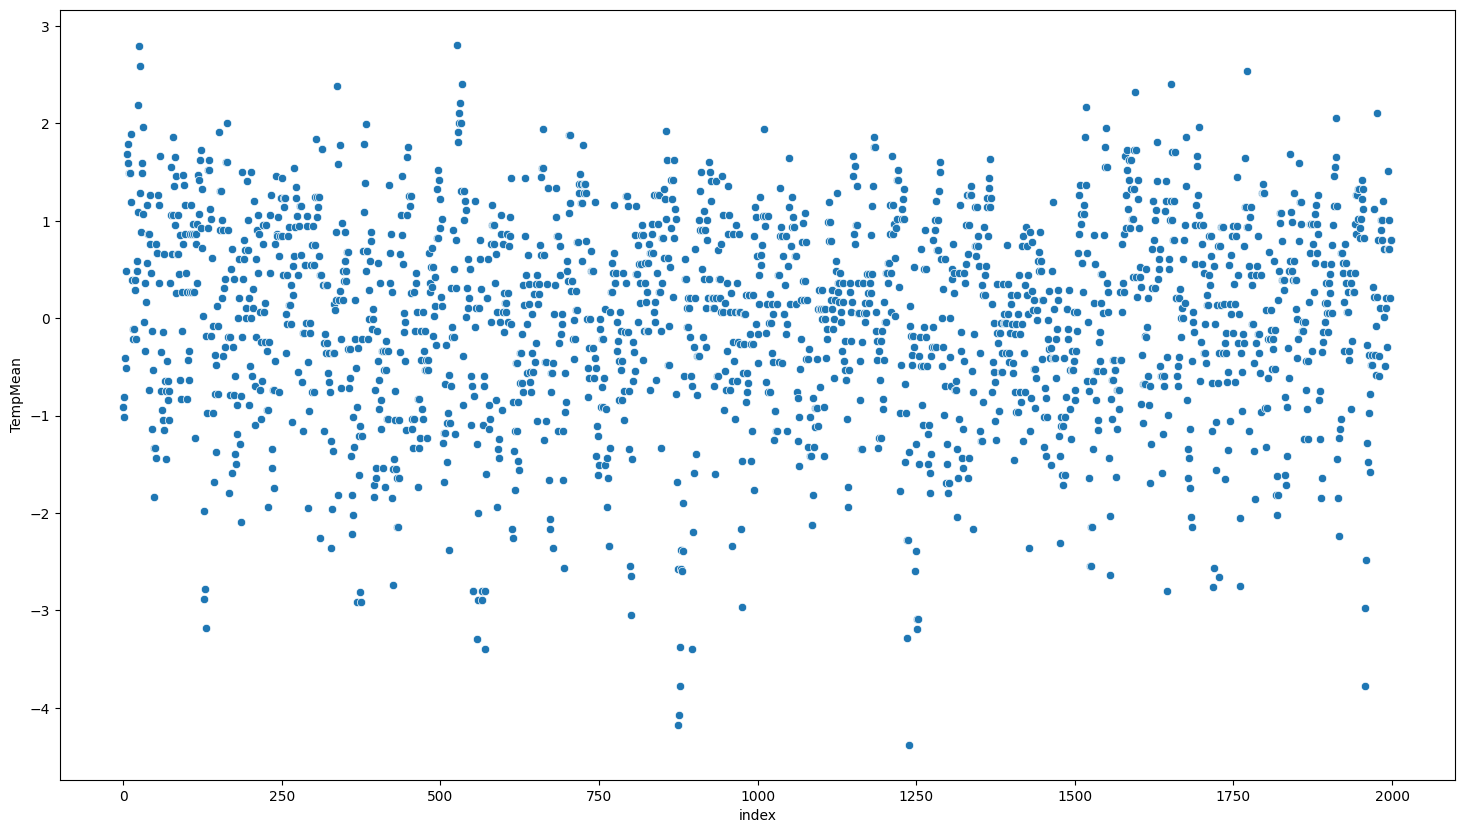

In [150]:
plt.figure(figsize=(18, 10))
sns.scatterplot(data=temperature_data, x='index', y='TempMean')
plt.show()

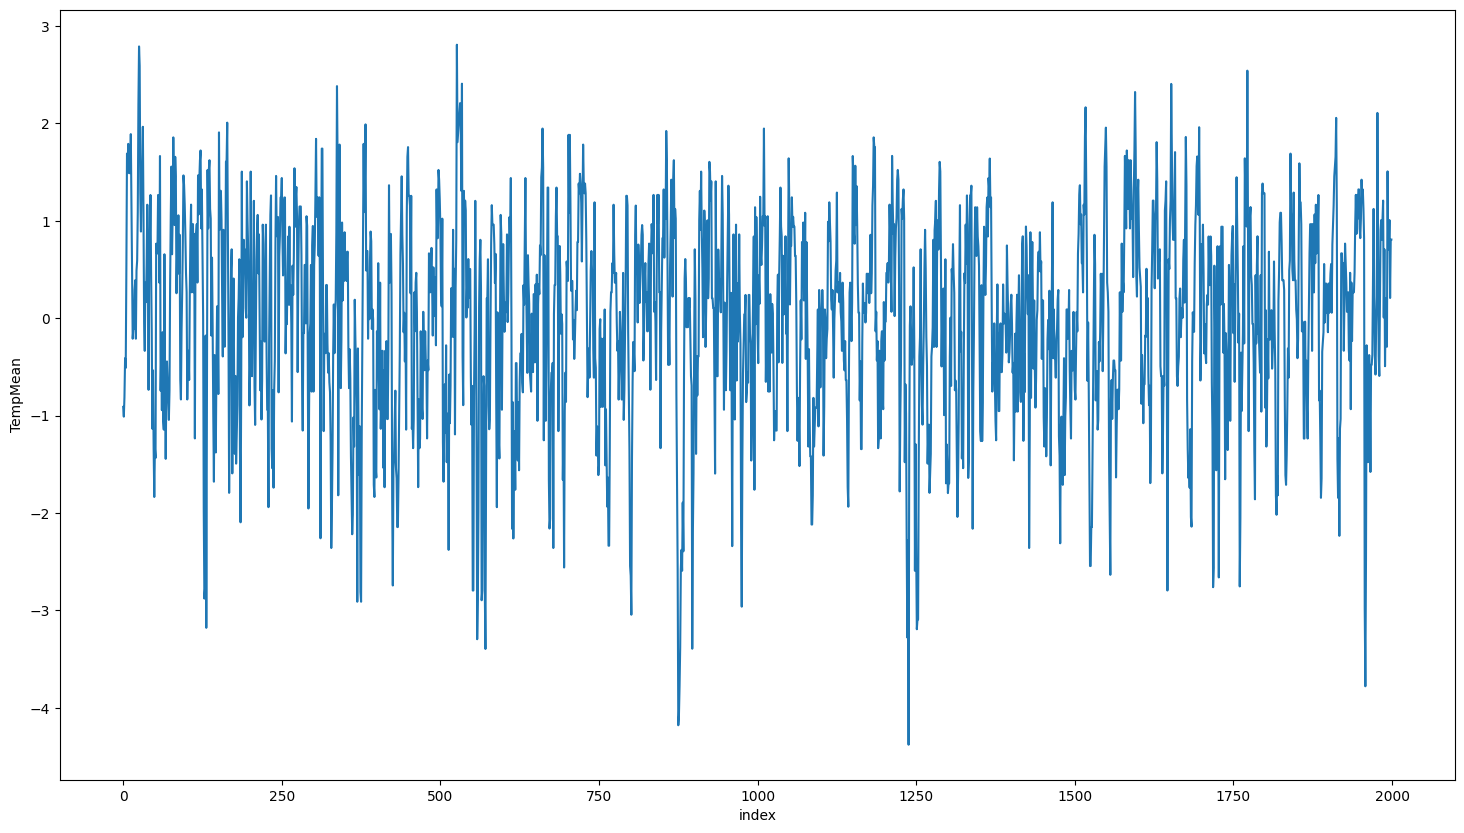

In [151]:
plt.figure(figsize=(18, 10))
sns.lineplot(data=temperature_data, x='index', y='TempMean')
plt.show()

# Sanity Check (From Source)

To make sure that our data does not have some lag - X correlation

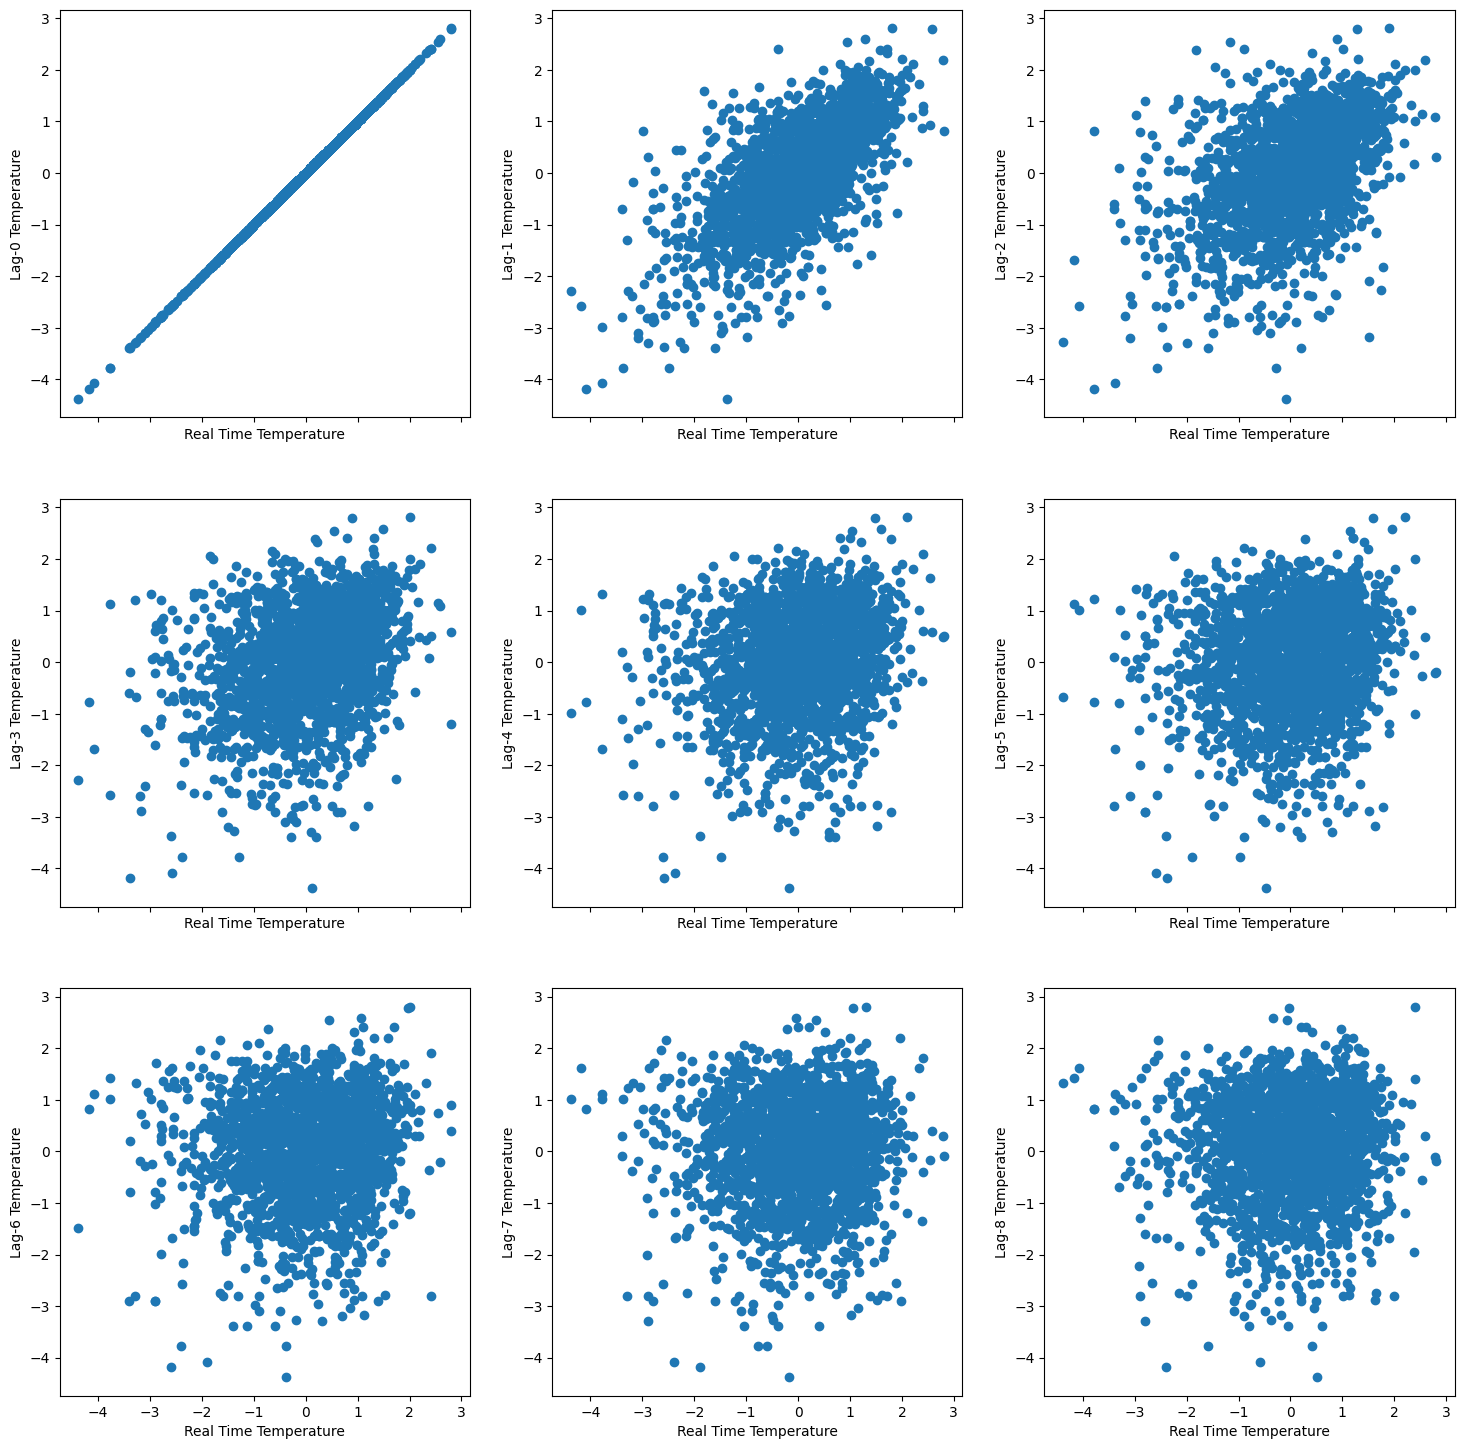

In [152]:
n = 9
current = temperature_data['TempMean'][n:]
fig, axis = plt.subplots(3, n//3, sharex=True, figsize=(18, 18))

for i in range(n):
  if i != 0:
    lag = temperature_data['TempMean'][(n-i):-i]
  else:
    lag = current
  axis[(i)//3, (i)%3].set(xlabel='Real Time Temperature', ylabel=f'Lag-{i} Temperature')
  axis[(i)//3, (i)%3].scatter(current, lag)

# Get Auto Regressive Order 
Using Autocorrelation and Partial Auto Correlation Of Data

The Only Interesting part here would be the Partial Autocorrelation of data where we should look for order at which the point is still outside of the box

c:\Users\Alaric\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


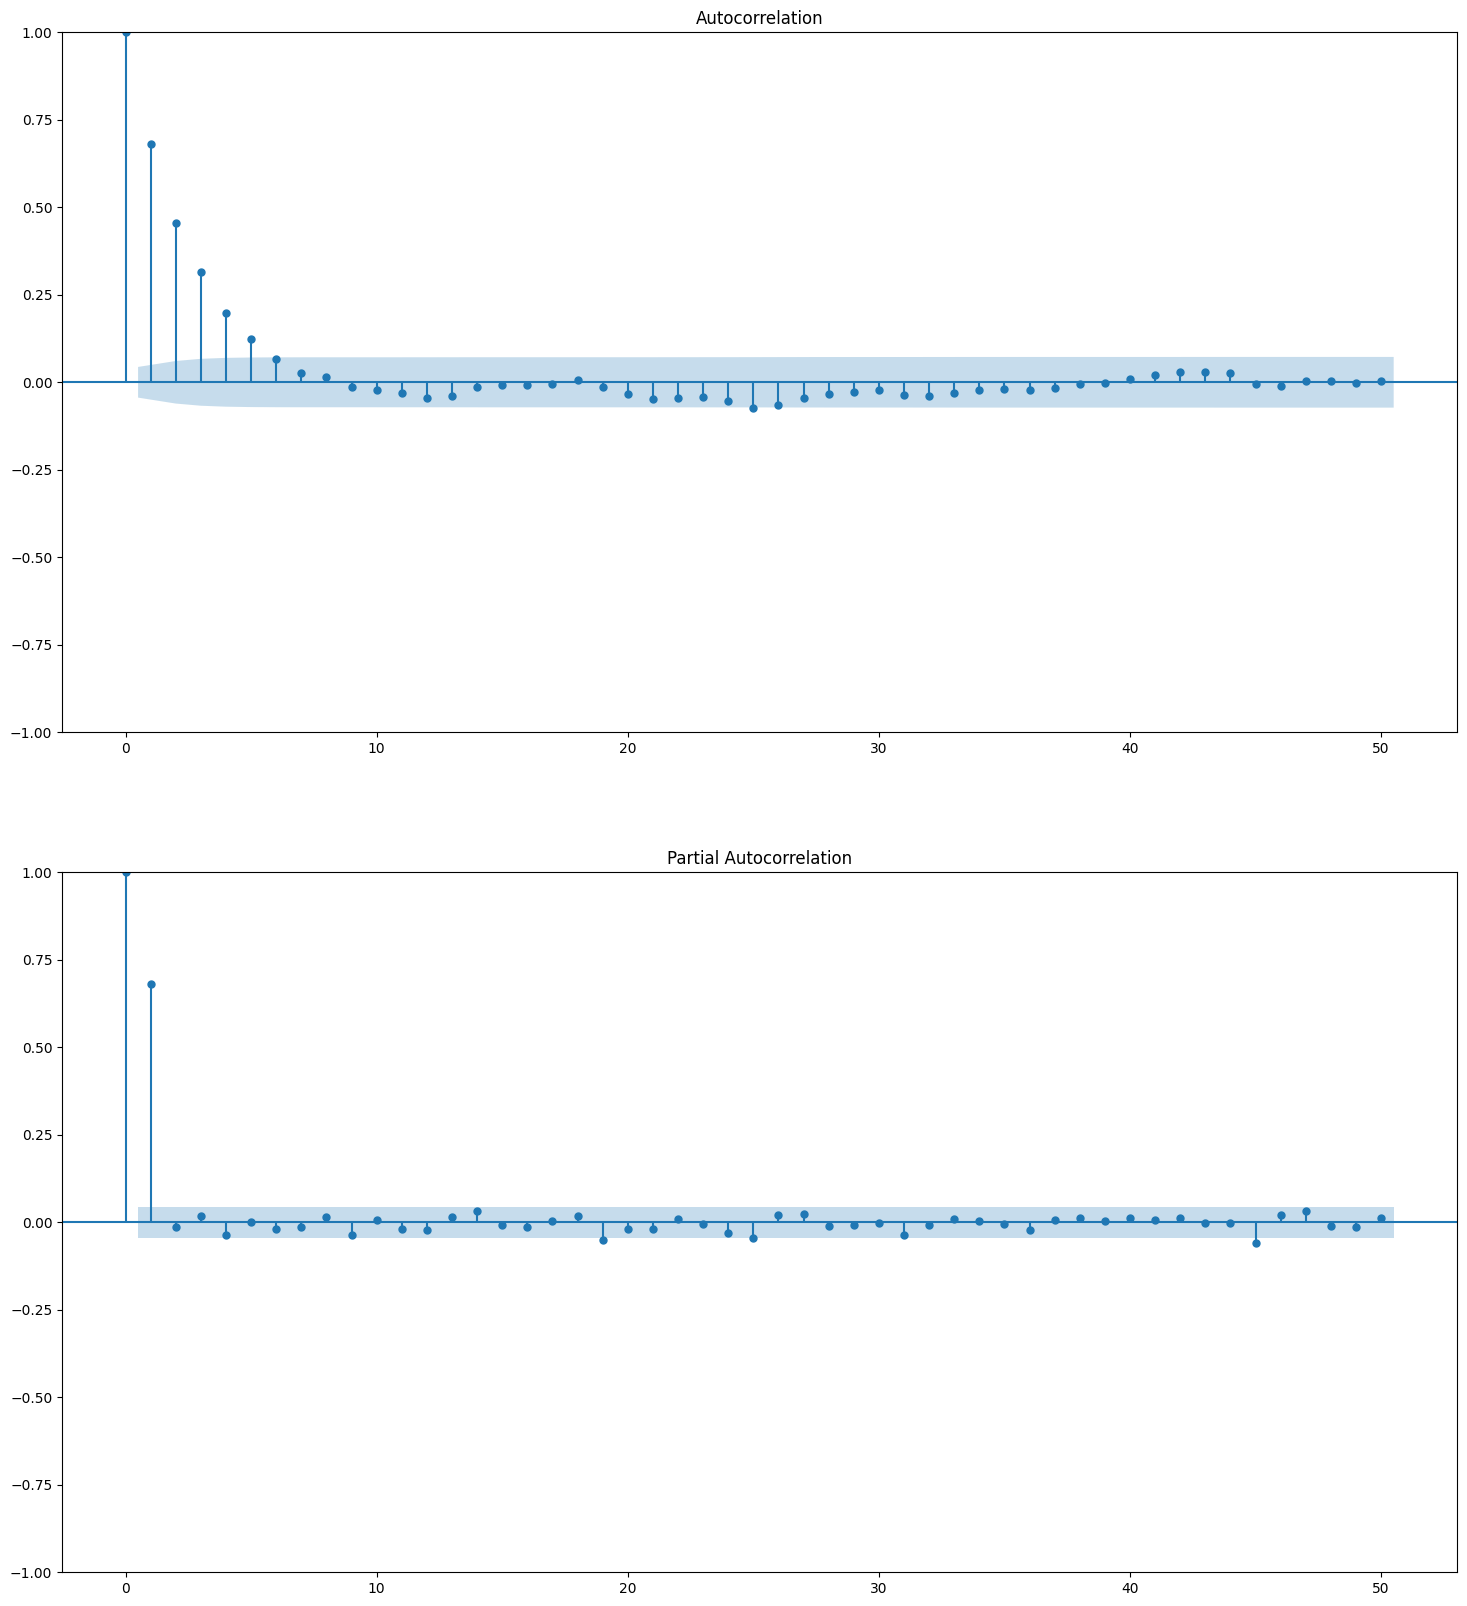

In [153]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, axes = plt.subplots(2, 1, figsize=(18, 20), sharey=True)

plot_acf(ax=axes[0], x=temperature_data['TempMean'], lags=50)
plot_pacf(ax=axes[1], x=temperature_data['TempMean'], lags=50)

plt.show()

# Training Proper

In [154]:
# Essentially also Sliding Window Length
Auto_Regressive_Order = 3

# Classifier from SciKit Family
Auto_Regressive_Model = RandomForestRegressor()

# Will be used later for Random Generation of Noise as Input
Model_Noise_Coefficient = None

In [155]:
# Generate Training X, and Y
X = temperature_data["TempMean"].copy().to_numpy()
TRAIN_X = []
TRAIN_Y = []

for i in range(len(X) - Auto_Regressive_Order):
    TRAIN_X.append(X[i : i + Auto_Regressive_Order])
    TRAIN_Y.append(X[i + Auto_Regressive_Order])

TRAIN_X = np.array(TRAIN_X, "float32")
TRAIN_Y = np.array(TRAIN_Y)

In [156]:
# Fit Data on Model
X_Std = np.std(X)
Auto_Regressive_Model.fit(TRAIN_X, TRAIN_Y)

RandomForestRegressor()

In [158]:
# Build Testing Data
# Copy Data to preserve Original Data
testing_temperature_data = data[["datetime", "temp"]].copy()

# Just Rename Data
testing_temperature_data.rename(columns={"datetime" : "Date", "temp" : "Temp"}, inplace = True)
testing_temperature_data.reset_index()

,index,Date,Temp
0,0,2001-01-01,25.2
1,1,2001-01-02,25.1
2,2,2001-01-03,25.3
3,3,2001-01-04,25.7
4,4,2001-01-05,25.6
...,...,...,...
8509,8509,2024-04-19,30.9
8510,8510,2024-04-20,31.1
8511,8511,2024-04-21,31.2
8512,8512,2024-04-22,31.6


In [159]:
X[0 : Auto_Regressive_Order]

array([-0.91075269, -1.01075269, -0.81075269])

In [160]:
X[Auto_Regressive_Order + 1]

-0.510752688172044

In [191]:
X

array([[-0.9107527 , -1.0107527 , -0.8107527 ],
       [-1.0107527 , -0.8107527 , -0.41075268],
       [-0.8107527 , -0.41075268, -0.5107527 ],
       ...,
       [ 0.7069364 ,  0.7069364 ,  1.0069364 ],
       [ 0.7069364 ,  1.0069364 ,  0.20693642],
       [ 1.0069364 ,  0.20693642,  0.80693644]], dtype=float32)

In [194]:
# Check on Testing Data

# MODEL PREDICT
n = len(testing_temperature_data)
# n = len(TRAIN_X)

predictions = []
predictions.extend(np.array(X[:Auto_Regressive_Order]))

# 0 -> Auto Regressive Order
sliding_window = np.array(X[-Auto_Regressive_Order : ])

for i in tqdm(range(n)):
    prediction_input = sliding_window.reshape(1, -1)
    current_prediction = Auto_Regressive_Model.predict(prediction_input)
    current_prediction += np.random.normal(loc = 0, scale = X_Std)
    # current_prediction += X_Std

    predictions.append(current_prediction[0])
    sliding_window = np.roll(sliding_window, -1)
    sliding_window[-1] = current_prediction[0]


100%|██████████| 8514/8514 [02:34<00:00, 54.96it/s]


In [195]:
fixed_predictions = np.array(predictions).reshape(-1, )
fixed_predictions.shape

(8517,)

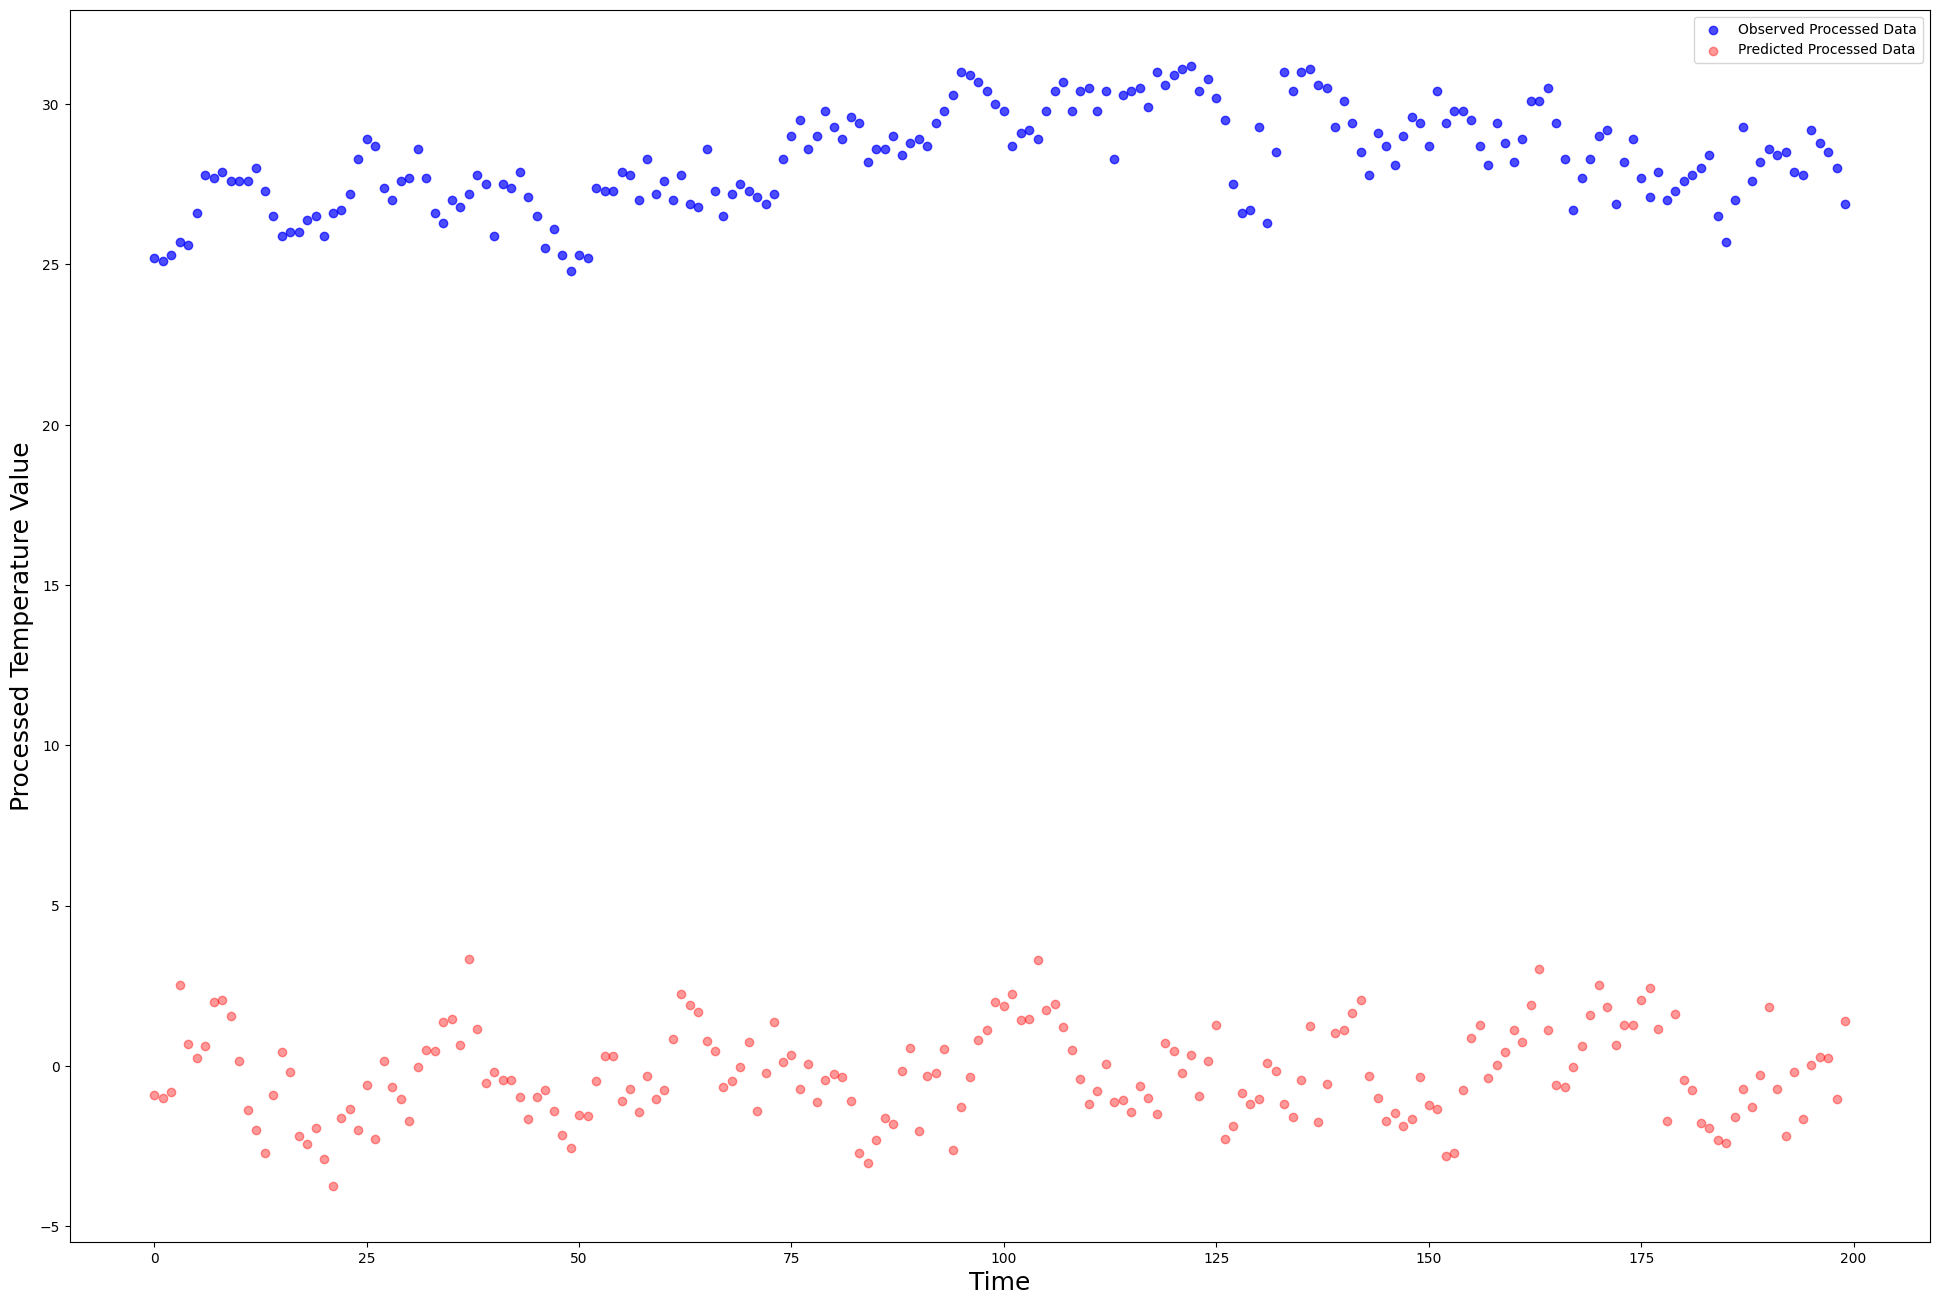

In [196]:
range_check = 200
real_data = testing_temperature_data["Temp"].to_numpy()[:range_check]
# real_data = X[:range_check]
pred_data = fixed_predictions[:range_check]

plt.figure(figsize=(24, 16))
plt.scatter(x=np.arange(range_check), y=real_data, color='blue', alpha=0.7)
plt.scatter(x=np.arange(range_check), y=pred_data, color='red', alpha=0.4)
plt.legend(loc='upper right', labels=['Observed Processed Data', 'Predicted Processed Data'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Processed Temperature Value', fontsize=18)
plt.show()

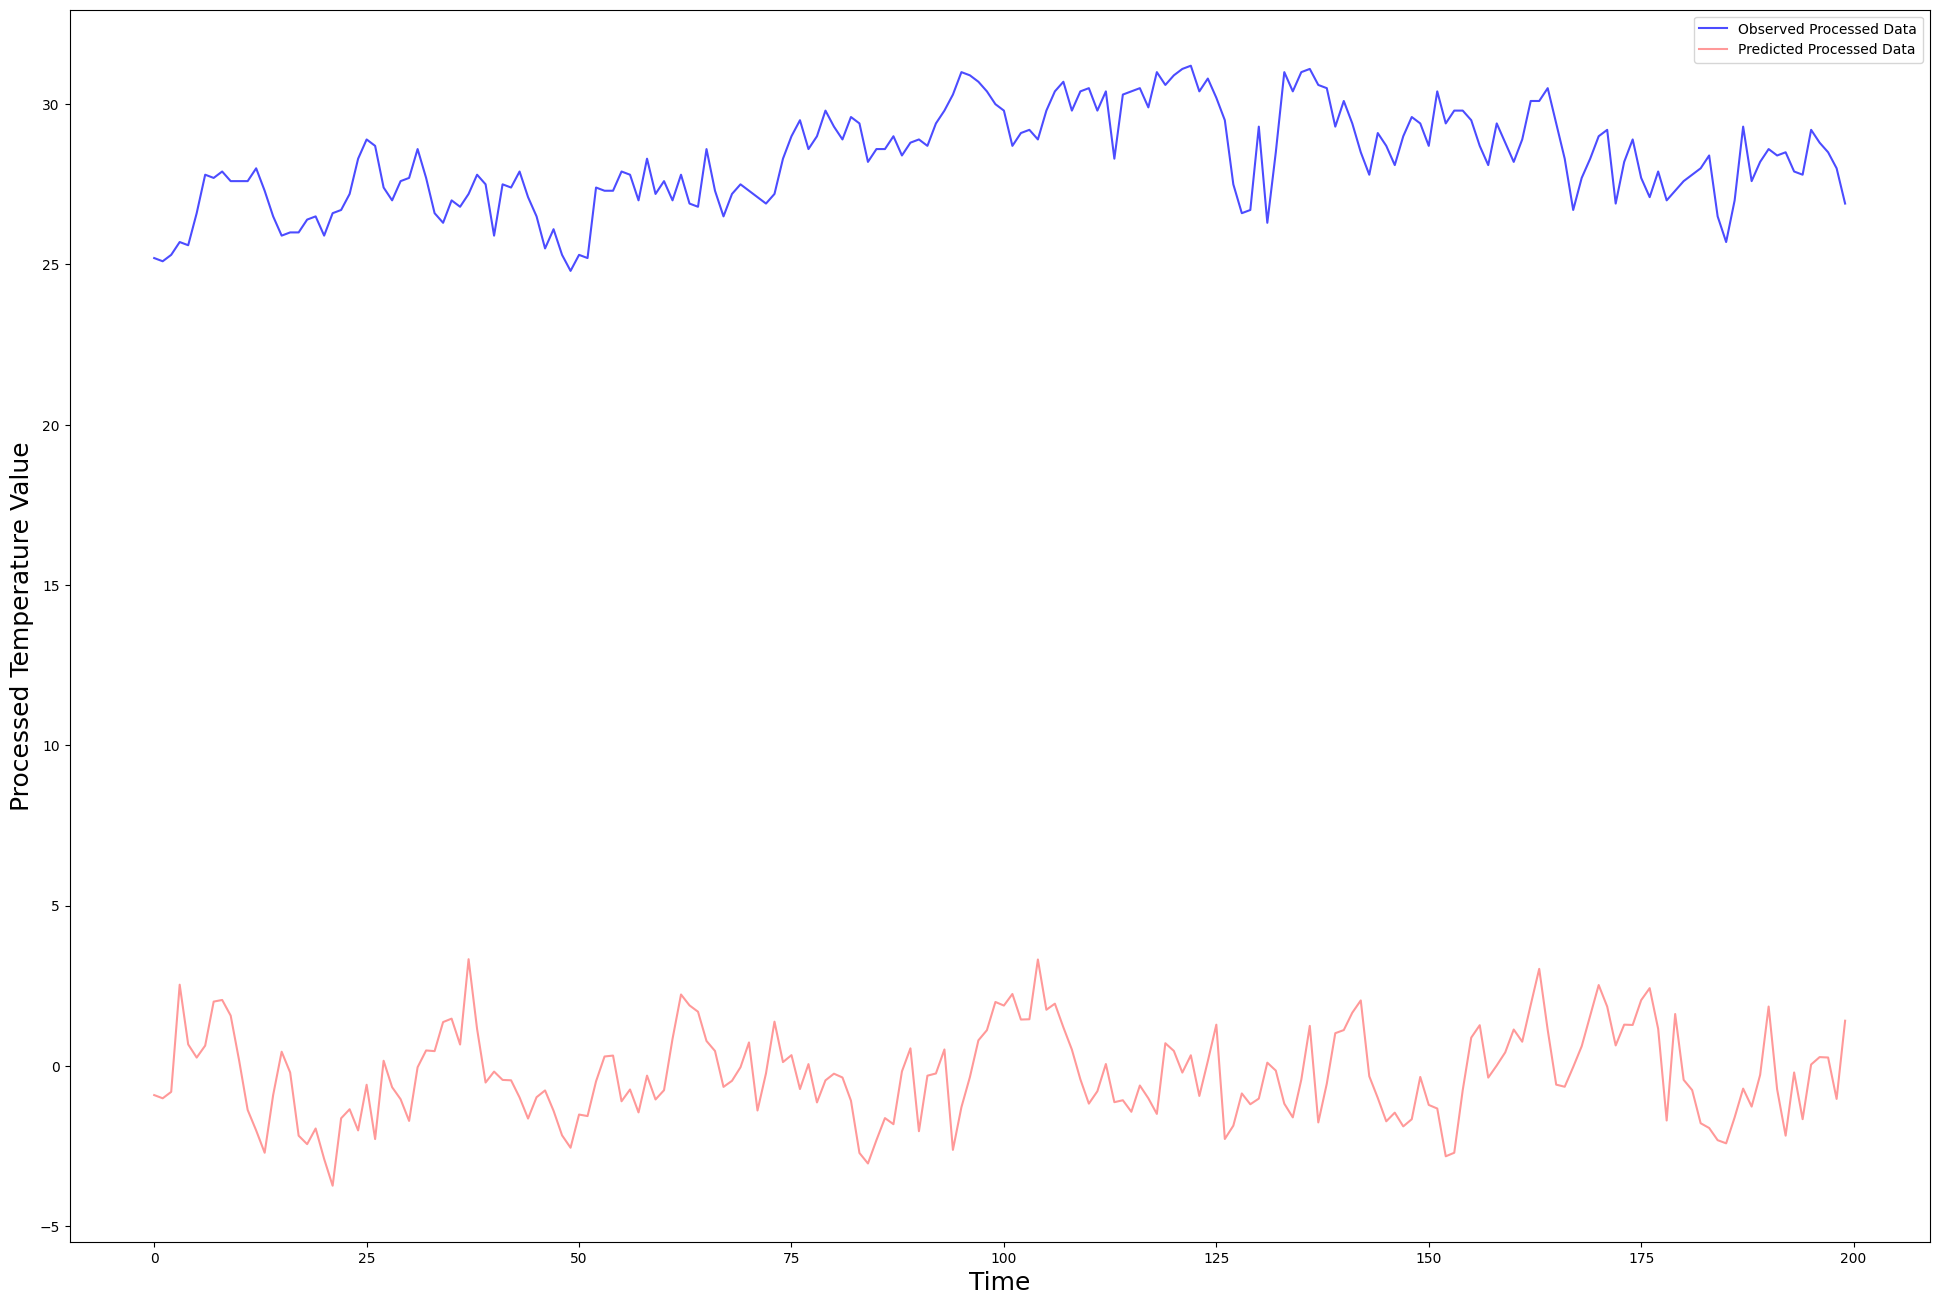

In [197]:
plt.figure(figsize=(24, 16))
plt.plot(real_data, color='blue', alpha=0.7)
plt.plot(pred_data, color='red', alpha=0.4)
plt.legend(loc='upper right', labels=['Observed Processed Data', 'Predicted Processed Data'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Processed Temperature Value', fontsize=18)
plt.show()

In [198]:
TRAIN_X.shape

(1997, 3)

In [199]:
fixed_predictions.shape

(8517,)

In [200]:
# Evaluate Models (Base)
preds = np.array(fixed_predictions.tolist()[Auto_Regressive_Order:]).reshape(-1, 1)
Auto_Regressive_Model.score(TRAIN_X, preds)

ValueError: Found input variables with inconsistent numbers of samples: [8514, 1997]

In [201]:
pred_dates = testing_temperature_data["Date"][:len(fixed_predictions)]
pred_df = pd.concat(objs=[pred_dates, pd.Series(fixed_predictions)], axis=1)
pred_df.columns = ["Date", "PredTemp"]
pred_df['Month'] = pd.DatetimeIndex(pred_df['Date']).month
pred_df['Zero'] = 0
pred_df = pred_df.reset_index()

In [202]:
# Adjust Predictions
# Return the Seasonality that was removed from training
# Use Monthly Means from previous transformation on training set

for month in pred_df["Month"].unique():
    pred_df.loc[pred_df["Month"] == month, "PredTemp"] += monthly_mean[month]
    pred_df.loc[pred_df["Month"] == month, "Zero"] += monthly_mean[month]

KeyError: nan

In [ ]:
pred_df

,index,Date,PredTemp,Month,Zero
0,0,2001-01-01,25.200000,1,26.110753
1,1,2001-01-02,25.100000,1,26.110753
2,2,2001-01-03,25.300000,1,26.110753
3,3,2001-01-04,26.970558,1,26.110753
4,4,2001-01-05,26.341473,1,26.110753
...,...,...,...,...,...
1995,1995,2006-06-19,28.940794,6,28.493064
1996,1996,2006-06-20,28.336451,6,28.493064
1997,1997,2006-06-21,28.361795,6,28.493064
1998,1998,2006-06-22,28.212311,6,28.493064


In [ ]:
# Add it again for the Display of seasonality thing (Make it show above)
for month in pred_df["Month"].unique():
    pred_df.loc[pred_df["Month"] == month, "Zero"] += monthly_mean[month]

In [ ]:
# Add the mean from the whole training set (Whole Training Set Seasonality)
pred_df["PredTemp"] += whole_training_set_mean
pred_df["Zero"] += whole_training_set_mean


In [ ]:
temperature_data

,index,Date,Temp,TempMean,Month,Year
0,0,2001-01-01,25.2,-0.910753,1,2001
1,1,2001-01-02,25.1,-1.010753,1,2001
2,2,2001-01-03,25.3,-0.810753,1,2001
3,3,2001-01-04,25.7,-0.410753,1,2001
4,4,2001-01-05,25.6,-0.510753,1,2001
...,...,...,...,...,...,...
1995,1995,2006-06-19,29.2,0.706936,6,2006
1996,1996,2006-06-20,29.5,1.006936,6,2006
1997,1997,2006-06-21,28.7,0.206936,6,2006
1998,1998,2006-06-22,29.3,0.806936,6,2006


In [ ]:
pred_df

,index,Date,PredTemp,Month,Zero
0,0,2001-01-01,25.200000,1,52.221505
1,1,2001-01-02,25.100000,1,52.221505
2,2,2001-01-03,25.300000,1,52.221505
3,3,2001-01-04,26.970558,1,52.221505
4,4,2001-01-05,26.341473,1,52.221505
...,...,...,...,...,...
1995,1995,2006-06-19,28.940794,6,56.986127
1996,1996,2006-06-20,28.336451,6,56.986127
1997,1997,2006-06-21,28.361795,6,56.986127
1998,1998,2006-06-22,28.212311,6,56.986127


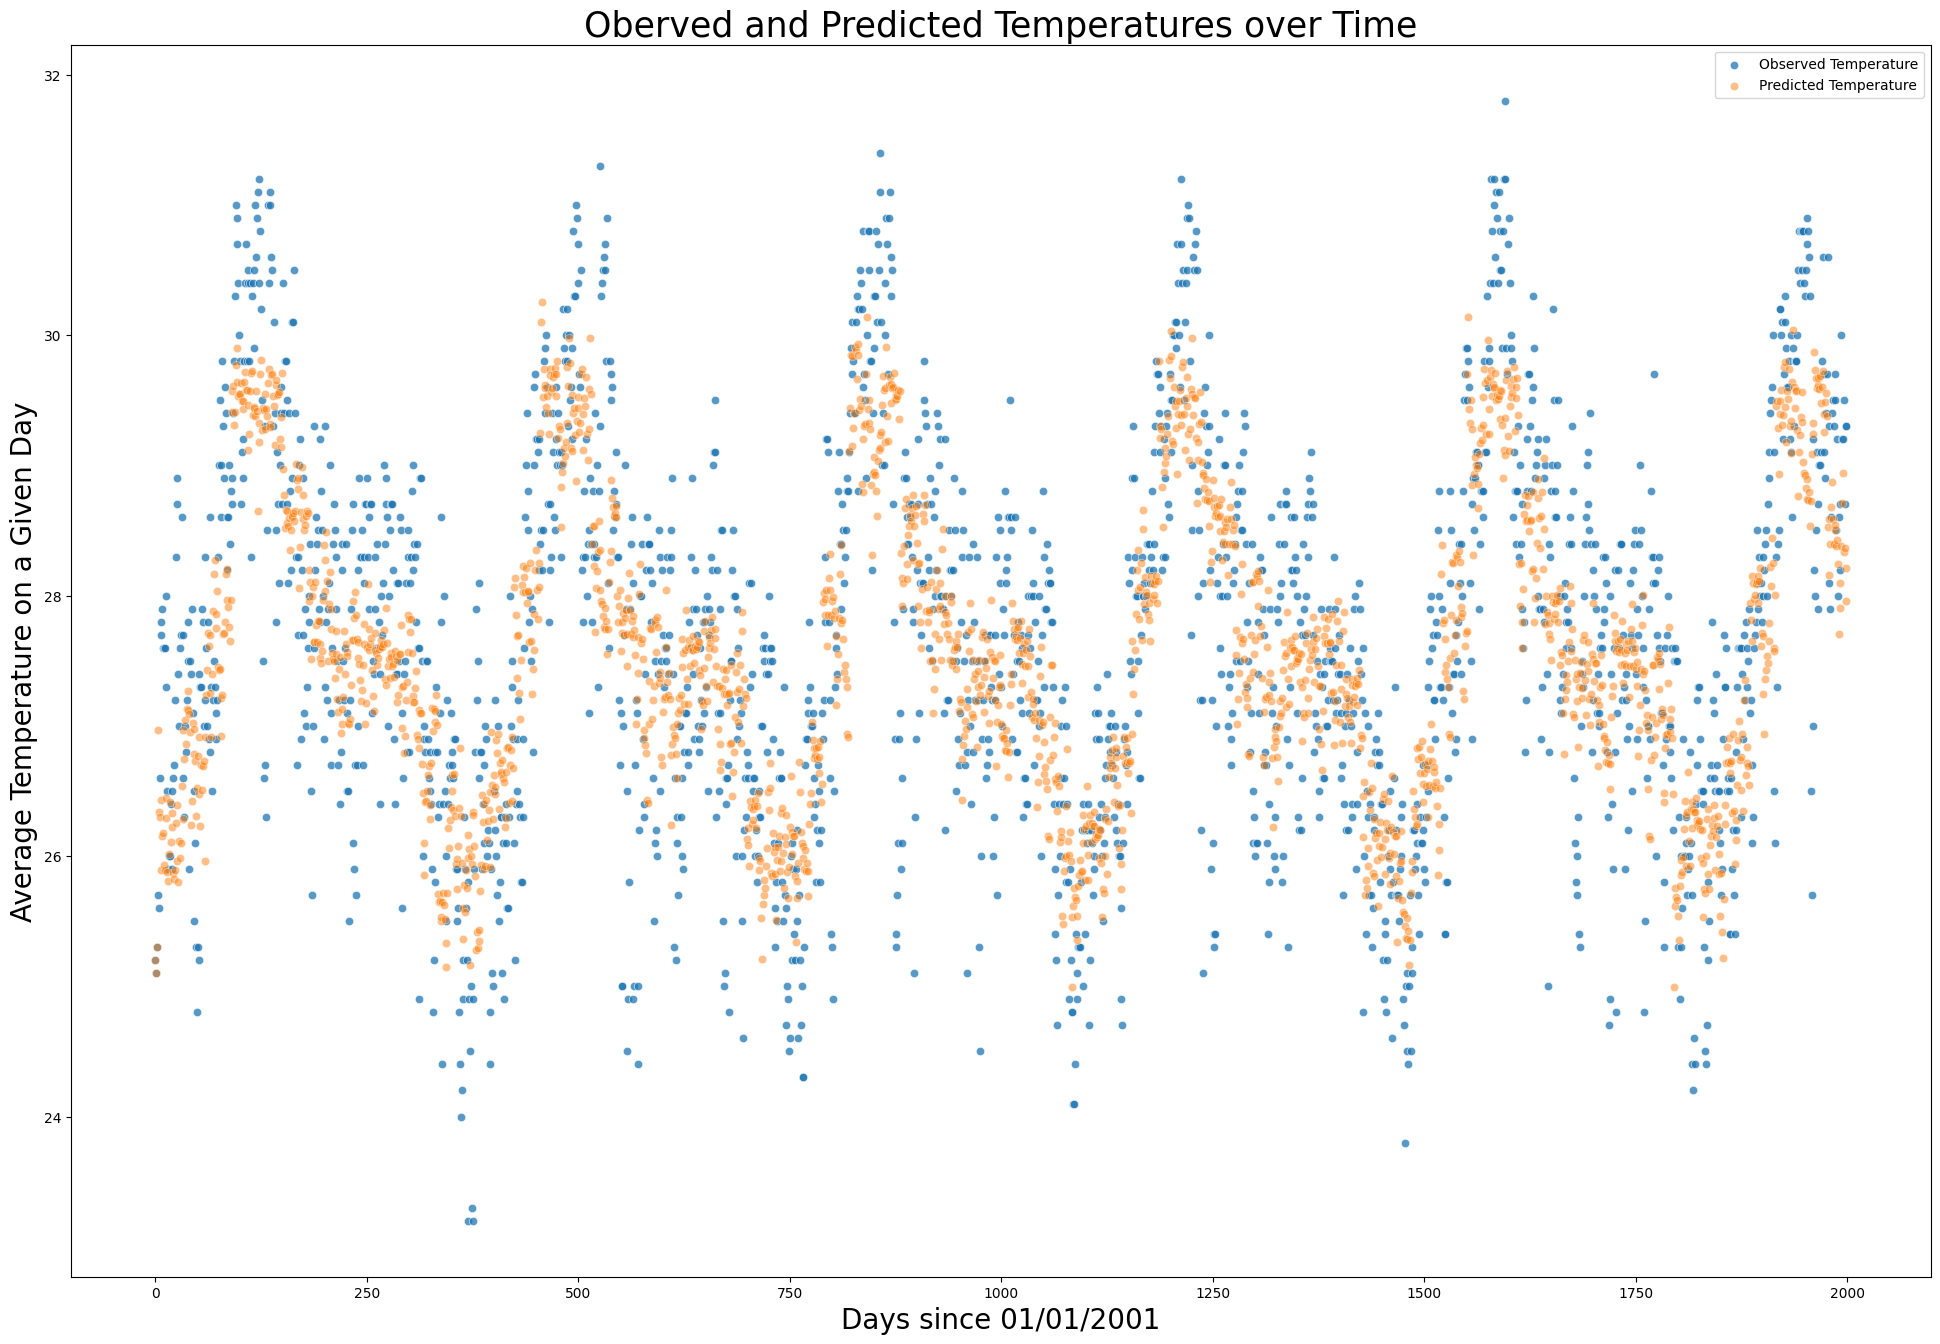

In [ ]:
plt.figure(figsize=(24, 16))
plt.title('Oberved and Predicted Temperatures over Time', fontsize=25)

sns.scatterplot(x=pred_df['index'], y=testing_temperature_data['Temp'], alpha=0.75)
sns.scatterplot(x=pred_df['index'], y=pred_df['PredTemp'], alpha=0.5)

plt.legend(loc='upper right', labels=['Observed Temperature', 'Predicted Temperature'])
plt.xlabel('Days since 01/01/2001', fontsize=20)
plt.ylabel('Average Temperature on a Given Day', fontsize=20)
plt.show()

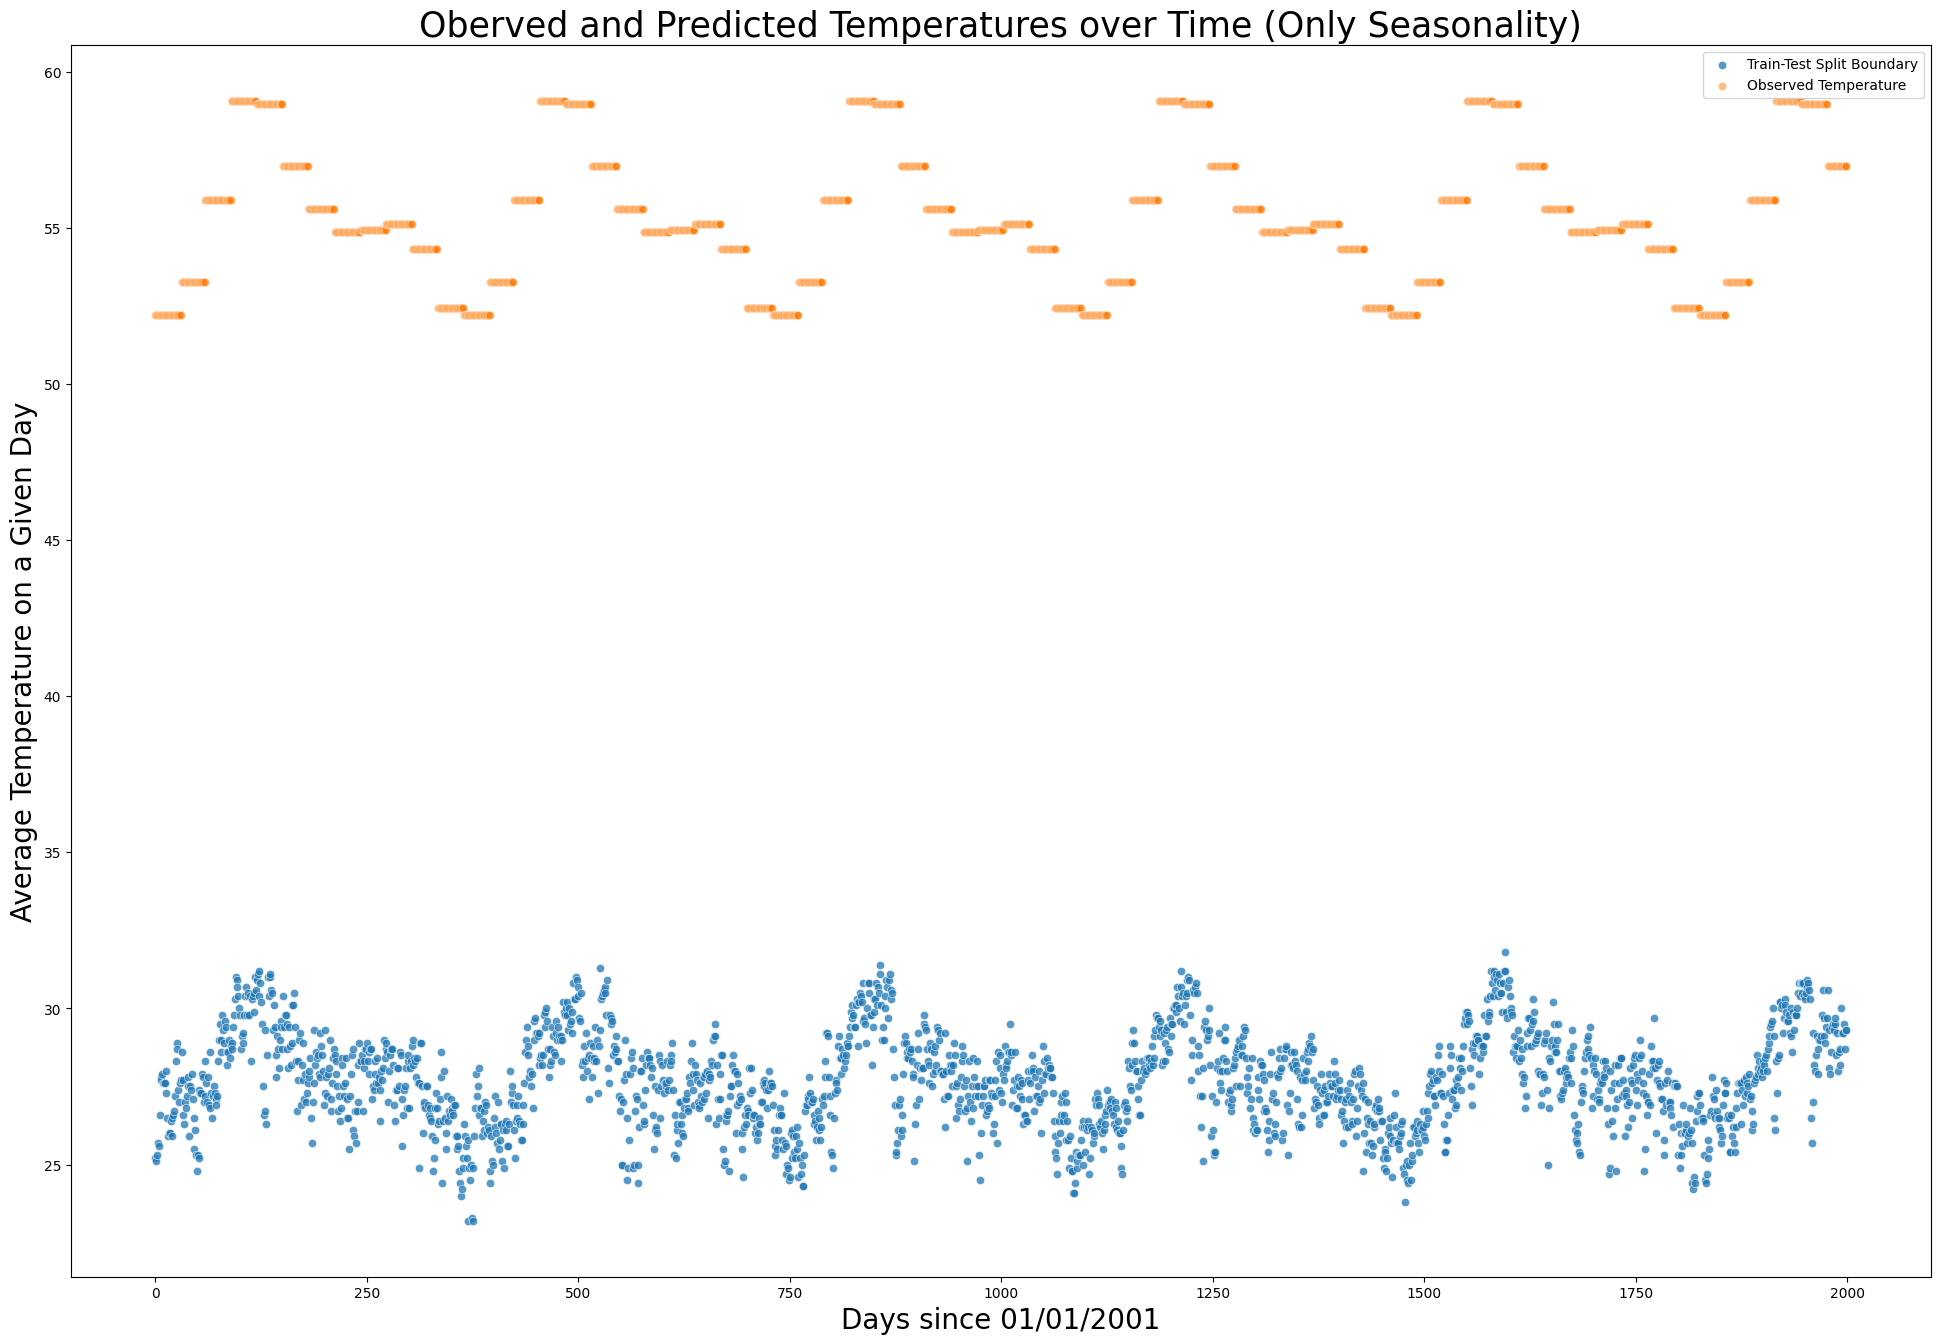

In [ ]:
plt.figure(figsize=(24, 16))
plt.title('Oberved and Predicted Temperatures over Time (Only Seasonality)', fontsize=25)

sns.scatterplot(x=pred_df['index'], y=testing_temperature_data['Temp'], alpha=0.75)
sns.scatterplot(x=pred_df['index'], y=pred_df['Zero'], alpha=0.5)

plt.legend(loc='upper right', labels=['Train-Test Split Boundary','Observed Temperature', 'Predicted Temperature'])
plt.xlabel('Days since 01/01/2001', fontsize=20)
plt.ylabel('Average Temperature on a Given Day', fontsize=20)
plt.show()

In [ ]:
# Use Ensemble Model

In [ ]:
# Evaluate Ensemble on Training Set

In [ ]:
# Evaluate Ensemble on Testing Set

In [ ]:
# Analysis on Means per Month and per Year (until 2010)

In [ ]:
# Analysis on Means per Month and per Year (until 2020)

In [ ]:
# Analysis on Means per Month and per Year (until 2024)